In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pingouin
from scipy.optimize import curve_fit
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from sklearn.preprocessing import MinMaxScaler
sns.set(rc={"figure.figsize":(5, 5), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 

%matplotlib inline

NB_CONTEXT_TYPES = 10
NB_OBJECT_TYPES = 10
NB_IMAGES = 600



In [ ]:
context_to_num = {'full context': 0, 'incongruent context':1, 
                  'no context':2, 'no object':3, 'blur context':4, 
                  'blur object':5, 'blur boundary':6, 'min context':7, 
                  'jigsaw context':8, 'textured context':9, 'all':10}
num_to_context = {value: key for key, value in context_to_num.items()}
colors = ['#3953A3', '#0B8040', '#EC2024', 'c', 'm', 'y', 'k', '#F06411', '#FFA500', '#800080', 'k']


model_groups = {
    'ResMem': 'Residual connections',
    'Inception3': 'Inception module',
    'GoogLeNet': 'Inception module',
    'ResNet101': 'Residual connections',
    'ResNet18': 'Residual connections',
    'ResNet50': 'Residual connections',
    'VGG19': 'Generic CNN',
    'AlexNet': 'Generic CNN',
    'DenseNet201': 'Residual connections',
    'MobileNet': 'Generic CNN',
    'MemNet': 'Generic CNN',
    'ResNet152': 'Residual connections',
    'Pixels': 'Pixels',
    'Neural': 'Neural',
    'ViT': 'Transformer',
    'ConvNeXt': 'Residual connections',
    'FasterRCNN': 'Recurrent ANNs',
    'SwinB': 'Transformer',
    'RegNetX': 'Generic CNN',
    'RetinaNet': 'Recurrent ANNs'
}

color_map={'low-level features':'w','Memorability':'r','Neural':'#545570', 'Inception module':'lightgreen', 'Generic CNN':'green', 'Residual connections':sns.palettes.color_palette()[2], 'Pixels':'k', 'Transformer':'b', 'Recurrent ANNs':'orange'}


def save(x, filename):
    pickle.dump(x, open(f'{filename}.pkl', 'wb'))

In [10]:
# Define the function with two sigmoid components
def mix_sigmoid(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a,b,d):
    sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
    sigmoid2 = a2 / (1 + np.exp(-(x - b2)/c2))
    sigmoid3 = a3 / (1 + np.exp(-(x - b3)/c3))
    return sigmoid1+ sigmoid2
def sigmoid(x, a1, b1, c1, d):
        sigmoid1 = a1 / (1 + np.exp(-(x - b1)/c1))
        return sigmoid1+d
def log_funct(x, a, b):
    return a * np.log(x) + b


def get_beh_signatures_from_acc(acc):
    
    I1_neural = acc
    images_indices = list(range(60))
    C1_neural_all_subsamples=[]
    for seed in range(10):
        np.random.seed(seed)
        c1_subsample = pd.DataFrame(acc.reshape(60,10)).loc[np.random.permutation(images_indices)[:50]].mean(axis=0).values
        C1_neural_all_subsamples.append(c1_subsample)
        
    C1_neural = [np.mean(I1_neural[i::NB_CONTEXT_TYPES]) for i in range(NB_CONTEXT_TYPES)]
    O1_neural = [np.mean(I1_neural[(i*NB_CONTEXT_TYPES):((i+1)*NB_CONTEXT_TYPES)]) for i in range(NB_CONTEXT_TYPES)]


    C1_extended_neural = [C1_neural[i % NB_CONTEXT_TYPES] for i in range(NB_IMAGES)]
    I1n_neural = np.array(I1_neural)-np.array(C1_extended_neural)
    return {'I1': I1_neural,
                           'C1_subsamples': np.array(C1_neural_all_subsamples),
                            'C1': np.array(C1_neural),
            'O1': np.array(O1_neural),
                           'I1n': I1n_neural
    }

def get_pcorr_extrapolation(x_data, y_data, std_data,plot, title,x_label='number of existing trials taken',y_label='% EV explained by neurons',funct=sigmoid, start=1, end=1000, log_scale=False, remove_thresh=0.001):

    params, covariance = curve_fit(funct, x_data, y_data,maxfev = 5000000)
    loss = np.sum((y_data - funct(x_data, *params)) ** 2)
    print('loss',loss)
    if plot:
 
        x_extrapolated = np.linspace(start, end, 100)  # Adjust the range as needed
        y_extrapolated = funct(x_extrapolated, *params)
        # Function to create an interactive scatter plot
        def plot_scatter(log_scale=False, y_limit=None, x_limit=None):
            plt.figure(figsize=(6, 6))

            plt.plot(x_extrapolated, y_extrapolated,  linestyle='--', color='red')
            plt.errorbar(x_data,y_data, yerr=std_data, alpha=0.1, c='gray', fmt='.')
            sns.scatterplot(x=x_data, y=y_data,  c='#545570', s=200)
            
            if log_scale:
                plt.xscale('log')
            if y_limit:
                plt.ylim(y_limit)
            if x_limit:
                plt.xlim(x_limit)
            

            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.title(signature)
            sns.despine()
            plt.axhline(y=26.9159758261, linestyle='dashed')
            plt.savefig(f'extrapolation_trials_{signature}.pdf')
            plt.show()

        # Create interactive widgets
        log_scale_checkbox = widgets.Checkbox(value=False, description='Log Scale')
        y_limit_slider = widgets.FloatRangeSlider(
            value=[0, np.max((max(y_data), max(y_extrapolated)))+std_data[-1]],
            min=np.max(np.min((min(y_data),min(y_extrapolated)), 0))-std_data[0],
            max=100,#np.max((max(y_data), max(y_extrapolated)))+10,
            step=0.1,
            description='Y limit',
        )
        x_limit_slider = widgets.FloatRangeSlider(
            value=[0, 40],
            min=0,
            max=end,
            step=1,
            description='X limit',
        )
        
        # Define the interactive function
        def update_plot(log_scale, y_limit, x_limit):
            plot_scatter(log_scale=log_scale, y_limit=y_limit, x_limit=x_limit)

        # Connect the widgets to the interactive function
        interactive_plot = interactive(update_plot, log_scale=log_scale_checkbox, y_limit=y_limit_slider, x_limit=x_limit_slider)

        # Display the interactive plot
        output = interactive_plot.children[-1]
        output.layout.height = '500px'
        display(interactive_plot)

    if loss>remove_thresh:
        print('loss > ', remove_thresh)
        return np.nan, loss

    x, a, b,c,d = sp.symbols('x a b c d')
    # Define the functions
    sigmoid = a / (1 + sp.exp(-(x - b))/c) +d
    log = a * sp.log(x) + b
    # Substitute specific parameter values
    if funct ==  log_funct:
        print('using log')
        a_v, b_v= params 
        funct_with_values = log.subs({a: a_v, b: b_v})
    else:
        print('using sigmoid')
        a_v, b_v,c_v,d_v = params 
        funct_with_values = sigmoid.subs({a: a_v, b: b_v,c:c_v,d:d_v})
    # Calculate the limit as x approaches positive infinity
    limit_at_infinity_specific = sp.limit(funct_with_values, x, sp.oo)

    return float(limit_at_infinity_specific), loss
self_consistency=pd.read_pickle('results/self_consistency.pkl')

def get_pcorr_limit_neurons(acc_neurons_subsb, title, idx=None, plot=False, remove_thresh=0.001): #acc_neurons_subsb for nb neurons seed
    
    neural_trials=acc_neurons_subsb#np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    x,y ='humans', 'pooled monkeys'
    df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx]
    pcorr, esv=dict(), {}
    for i_trials in acc_neurons_subsb.keys():
        pcorr[i_trials], esv[i_trials]=[],[]
        for i_seed in range(len(acc_neurons_subsb[i_trials])):
            #df_human_monkey=pd.DataFrame(get_beh_signatures_from_acc(all_trials[x][i_trials][i_seed])[signature], columns=[x])
            #df_human_monkey[y]=get_beh_signatures_from_acc(all_trials[y][i_trials][i_seed])[signature]
            df_model=pd.DataFrame(get_beh_signatures_from_acc(neural_trials[i_trials][i_seed])[signature])
            partial_correlation = pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]
            pcorr[i_trials].append(partial_correlation)
            correlation_hm=df_human_monkey.corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])
            esv[i_trials].append(((correlation_hm**2-partial_correlation**2)/(correlation_hm**2))*100)
            #if i_trials==9:
            #    print(signature, pcorr[i_trials])
    var_to_plot=esv
    limit, loss = get_pcorr_extrapolation(log_scale=False, y_label='Partial correlation' if var_to_plot==pcorr else '% Explained Variance by IT', x_data = list(var_to_plot.keys()),
                                          y_data = np.array([np.nanmean(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), title=title,std_data= np.array([np.nanstd(var_to_plot[i_trials]) for i_trials in var_to_plot.keys()]), plot=plot, remove_thresh=remove_thresh )
    if var_to_plot==pcorr:
        limit_r = np.nan if (limit >=0.9) or (limit<=0) else limit
    else:
        limit_r= limit
    return limit_r, loss 


In [11]:

acc_mean_dic=pd.read_pickle('results/no_dd/acc_all_bins/7:10.pkl')
acc_mean_dic=pd.read_pickle('results/no_dd/acc_600_decoding_5f_122n_7_17_no_dd_splits.pkl')
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates_all.pkl')
signature='I1'
limit,loss = get_pcorr_limit_neurons(acc_mean_dic,title=signature, plot=True, 
            idx=list(range(10 if signature=='C1' else 600)), remove_thresh=2000)

print('limit: ', limit)

loss 30.441763784564635


interactive(children=(Checkbox(value=False, description='Log Scale'), FloatRangeSlider(value=(5.62059278305643…

using sigmoid
limit:  26.9159758261


In [12]:
get_pcorr_extrapolation(log_scale=False,x_data = list(range(1,31)),
 y_data = np.array([np.mean(acc_mean_dic[i_trials]) for i_trials in acc_mean_dic.keys()]), 
                        title=signature,
                        std_data= np.array([np.nanstd(acc_mean_dic[i_trials])/np.sqrt(100) for i_trials in acc_mean_dic.keys()]), 
                        funct=log_funct,plot=True, remove_thresh=0.02,y_label=' Decoding Accuracy' )


loss 0.0004646654073032157


interactive(children=(Checkbox(value=False, description='Log Scale'), FloatRangeSlider(value=(0.50871459144308…

using log


(inf, 0.0004646654073032157)

In [13]:
def get_pcorr(model_acc, signature, title,idx=None,plot=False, remove_thresh=0.001, neural=False, llfeats=False): 

    x,y ='humans', 'pooled monkeys'
    model_trials= model_acc
    if signature == 'C1_subsamples':
        df_human_monkey = pd.DataFrame((beh_sig_sbj['C1_subsamples'][x][idx],beh_sig_sbj['C1_subsamples'][y][idx])).T
        df_human_monkey.columns=[x,y]
        df_model=pd.DataFrame(model_trials).iloc[idx]
        return pd.concat((df_human_monkey, df_model), axis=1).pcorr()[x][y], 0
    else:
        df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
        df_model=pd.DataFrame(model_trials)
    return pd.concat((df_human_monkey, df_model), axis=1).iloc[idx].pcorr()[x][y]    
def distribution_info(corr_coefs):
    #corr_coefs = list(sum(corr_coefs,()))
    return (np.nanmean(corr_coefs), np.nanstd(corr_coefs), np.nanmax(corr_coefs), np.nanmin(corr_coefs), corr_coefs)

low_level_feats = pd.read_pickle('../../prediction_demo/monkey_data/low-level_features.pkl')



In [ ]:
low_level_feats = pd.read_pickle('../../prediction_demo/monkey_data/low-level_features.pkl')
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')

esv=dict()
splits=dict()
# subsample 300 images 20 times for the image-level analysis       
splits['I1']=nsplits=np.array([
[
    np.random.seed(seed), 
    np.random.permutation(NB_IMAGES)[:NB_IMAGES//2],
    np.random.seed(seed),
    np.random.permutation(NB_IMAGES)[NB_IMAGES//2:]
][1::2] # Extracting the results excluding the seed setting
for seed in range(10) 
]).reshape((20, 300))   
np.random.seed(565)
num_bootstraps = 20
splits['I1'] = [np.random.choice(list(range(NB_IMAGES)), size=NB_IMAGES, replace=True) for _ in range(num_bootstraps)]
splits['C1']= [np.random.choice(list(range(NB_CONTEXT_TYPES)), size=NB_CONTEXT_TYPES, replace=True) for _ in range(num_bootstraps)]
splits['I1n']=splits['I1']

full_decode_acc_models=pd.read_pickle('results/acc_all_models_3k_no_dd.pkl') 
llfeats_dict = dict(zip(low_level_feats.columns,low_level_feats.values.T))
full_decode_acc_models.update(llfeats_dict)
full_decode_acc_models['Neural']=pd.read_pickle(f'results/no_dd/acc_600_decoding_5f_122n_7_17_svm_pc_nodd.pkl')

band_mh=dict()
for signature in ['C1','I1','C1_subsamples', 'I1n']:
    x,y ='humans', 'pooled monkeys'
    esv[signature]=dict()
    for model in full_decode_acc_models.keys():
        print(model)
        esv[signature][model]=[]
        band_mh[signature]=[]
        for idx_subsample in splits[signature]:
            if signature=='C1_subsamples':
                corr_coef_mh = np.corrcoef(beh_sig_sbj['C1_subsamples'][x][idx_subsample], beh_sig_sbj['C1_subsamples'][y][idx_subsample])[0,1]
                corr_mh = corr_coef_mh
            else:
                corr_mh = pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx_subsample].corr()[x][y]
            band_mh[signature].append(corr_mh)
            limits=[]
            acc_model=full_decode_acc_models[model]
            if model == 'Neural extrapolated':
                model_signature=acc_model
                limit, losses = get_pcorr_limit_neurons(acc_mean_dic,title=signature, plot=True, 
                    idx=idx_subsample,#list(range(10 if (signature=='C1') or (signature=='O1') else 600)), 
                    remove_thresh=2000)
                
            else:
                model_signature=get_beh_signatures_from_acc(acc_model)[signature]
                limit, losses = get_pcorr(model_signature, title='', idx=idx_subsample,signature=signature, plot=True,remove_thresh=0.001 if signature=='I1' else 0.003, neural=(model=='Neural'), llfeats=(model in llfeats_dict.keys()))
           
            esv[signature][model].append((((corr_mh**2)-(limit**2))/(1))*100) #(corr_mh**2)
            


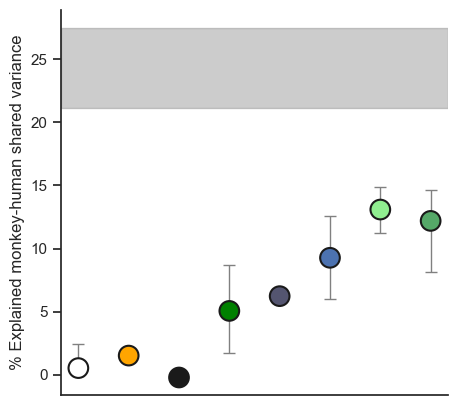

In [21]:


color_map={'low-level features':'w','Memorability':'r','Neural':'#545570', 'Inception module':'lightgreen', 'Generic CNN':'green', 'Residual connections':sns.palettes.color_palette()[2], 'Pixels':'k', 'Transformer':'b', 'Recurrent ANNs':'orange'}
#signature='C1'
#full_decode_acc_models['Neural extrapolated']=full_decode_acc_models['Neural']
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']

signature='I1'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])

mean = df.mean().sort_values()
std=df.std()[mean.index]
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)
df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
df['acc']=pd.DataFrame(acc_models, index=['acc']).T


df['Group'] = df.index.map(model_groups)
df['Group'].fillna('low-level features', inplace=True)

df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed' 
df['colors'] = df['Group'].map(color_map)
df.loc['Pixels', 'linestyle'] = 'dashed'  

df_grouped=df.groupby('Group').aggregate(np.mean)#.sort_values('mean')
df_grouped['std']=df.groupby('Group').aggregate(np.nanstd)['mean']
df_grouped['max']=df.groupby('Group').aggregate(np.max)['mean']
df_grouped['min']=df.groupby('Group').aggregate(np.min)['mean']
df_grouped['acc']=df.groupby('Group').aggregate(np.nanmean)['acc']
df_grouped['acc'].loc['low-level features']=0


df_grouped=df_grouped.sort_values('acc', ascending=True)#.loc[sorted_groups]

d=df.groupby('Group').aggregate(lambda x: [x.values])['mean'].apply(lambda x: x[0])


ax =sns.scatterplot(data=df_grouped, x=df_grouped.index, y='mean', linewidth=1.5, palette=color_map,
                  hue='Group', legend=False, s=200, edgecolor='k',zorder=3)#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
#ax.errorbar(x=df_grouped.index, y=df_grouped['mean'], yerr=df_grouped['std'],fmt='None' ,c='grey',  alpha=0.7)
ax.errorbar(x=df_grouped.index, y=df_grouped['mean'], yerr=[df_grouped['mean']-df_grouped['min'], df_grouped['max']-df_grouped['mean']], 
            fmt='None', color='grey', elinewidth=1, capsize=4, capthick=1, zorder=2)

ax.axhspan(ymin=mh_info[0]-mh_info[1],ymax=mh_info[0]+mh_info[1],  alpha=0.4, color='gray')



plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()
# Setting the new ticks without changing labels
plt.xticks(rotation=60, ha='right') 

plt.xlabel('')
ax = plt.gca()
xticks_labels =ax.get_xticklabels()# [label.get_text() for label in ax.get_xticklabels()]

ax.set_xticklabels([])
ax.set_xticks([])
plt.savefig(f'{signature}_grouped_models.pdf')
plt.show()

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_44908/1339747975.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=15)
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_44908/1339747975.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=ax.get_yticklabels(),fontsize=15)


,mean,acc
mean,1.000000,0.945579
acc,0.945579,1.000000


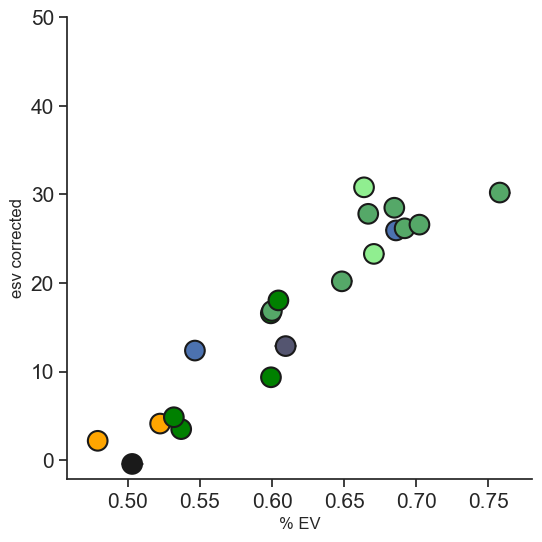

In [24]:


color_map={'low-level features':'w','Memorability':'r','Neural':'#545570', 'Inception module':'lightgreen', 'Generic CNN':'green', 'Residual connections':sns.palettes.color_palette()[2], 'Pixels':'k', 'Transformer':'b', 'Recurrent ANNs':'orange'}
#signature='C1'
#full_decode_acc_models['Neural extrapolated']=full_decode_acc_models['Neural']
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
acc_models_std=dict([(model, full_decode_acc_models[model].std() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])


del acc_models['peak power']
del acc_models_std['peak power']
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from sklearn.preprocessing import MinMaxScaler
sns.set(rc={"figure.figsize":(6, 6), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 

%matplotlib inline
signature='I1'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])

mean = df.mean().sort_values()
std=df.std()[mean.index]
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)

df =pd.DataFrame(mean, columns=['mean'])
df['esv corrected']=df['mean']/(np.nanmean(band_mh[signature])**2)
df['std']=std
df['acc']=pd.DataFrame(acc_models, index=['acc']).T
df['acc std']=pd.DataFrame(acc_models_std, index=['acc']).T

df['Group'] = df.index.map(model_groups)
df['Group'].fillna('low-level features', inplace=True)
#df=df.sort_values(['Group', 'mean'], ascending=[False, True])

df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df['colors'] = df['Group'].map(color_map)
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df=df.dropna()
ax =sns.scatterplot(data=df, x='acc', y='esv corrected', linewidth=1.5, palette=color_map,zorder=2,
                 edgecolor='k',hue='Group',legend=False, s=200)#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}

plt.errorbar(x=df['acc'], y=df['esv corrected'],yerr=df['std'], xerr=df['acc std']/np.sqrt(600), zorder=1,fmt='None', c='k', alpha=0.4)
sns.despine()
#plt.legend(frameon=False, title='Model architecture')
plt.xlabel('accuracy')
ax.set_xticklabels(labels=ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(labels=ax.get_yticklabels(),fontsize=15)
plt.ylim(None, 100)
plt.savefig(f'{signature}_anns_ev_vs_acc.pdf')
pd.concat((df['mean'], df['acc']), axis=1).corr()

In [443]:
valid_trials=pd.read_pickle('results/valid_trials_per_sbj.pkl')
shc={}
sbj='pooled monkeys'
for i in range(10):
    images_context=list(range(i,600,10))
    shc[i] = get_splithalf_corr_subsample(valid_trials[sbj], idx=images_context, return_all=True, num_seeds=100)


number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7398 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7794 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7825 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.6715 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7411 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7080 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7832 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7710 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7975 
number of images: 600, number of trials: 22
Average split-half c

In [493]:
sbj='neurons'
shc_neurons=pd.read_pickle('shc_7_17_all_context.pkl')
shc={}
for i in shc_neurons.keys():
    shc[i]=shc_neurons[i]['I1_decode'].mean(axis=1)



In [698]:

mean=pd.DataFrame(shc).mean()
std=pd.DataFrame(shc).std()


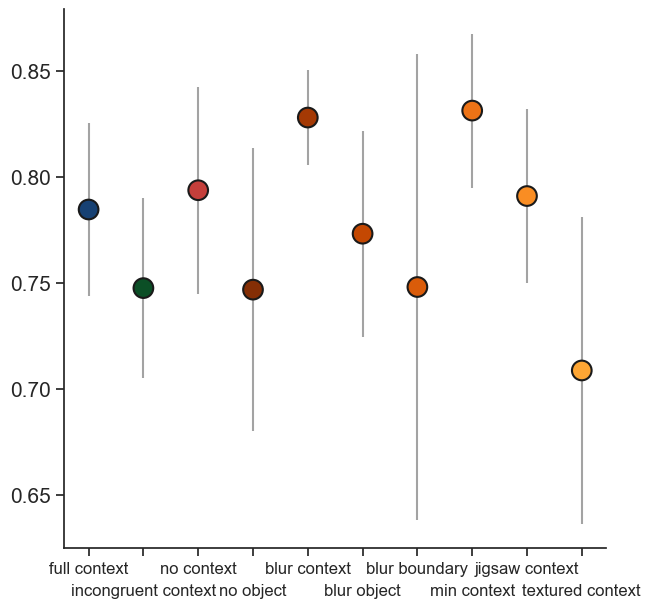

In [498]:
sns.set(rc={"figure.figsize":(7, 7), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 

ax =sns.scatterplot( x=mean.index, y=mean.values, linewidth=1.5, palette=combined_palette,zorder=2,
                 edgecolor='k',legend=False,hue=mean.index, s=200)#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
plt.errorbar(x=mean.index, y=mean.values,yerr=std.values, zorder=1,fmt='None', c='k', alpha=0.4)
labels=list(context_to_num.keys())
plt.xticks(range(len(labels)), labels, rotation=0)

for i, label in enumerate(labels):
    if i % 2 == 1:
        plt.gca().get_xticklabels()[i].set_position((0, -0.04))

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
sns.despine()
plt.xlabel('')
plt.savefig(f'{sbj}_self_consistency.pdf')

In [476]:
valid_trials=pd.read_pickle('results/valid_trials_per_sbj.pkl')
shc={}
sbj='pooled monkeys'
for i in range(2,valid_trials[sbj].shape[1]+1,2):
    images_context=list(range(600))
    shc[i] = get_splithalf_corr_subsample(valid_trials[sbj], idx=images_context, return_all=True, num_seeds=100,nb_trials_subsample=i )



number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.2474 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.3842 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.4743 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.5526 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.6023 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.6453 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.6783 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7041 
number of images: 600, number of trials: 22
Average split-half correlation across 100 seeds I1: 0.7241 
number of images: 600, number of trials: 22
Average split-half c

In [488]:
sbj='neurons'
shc_neurons=pd.read_pickle('shc_7_17_all_trials.pkl')
shc={}
for i in shc_neurons.keys():
    shc[i]=shc_neurons[i]['I1_decode'].mean(axis=1)


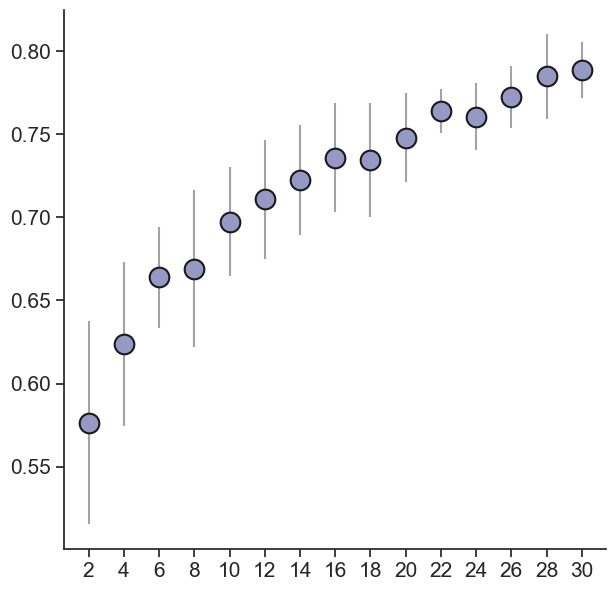

In [492]:
mean=pd.DataFrame(shc).mean()
std=pd.DataFrame(shc).std()
sns.set(rc={"figure.figsize":(7, 7), 'font.family':'arial', 'font.size': 8})
#'#008080', '#F26F63', '#9699C3',
colors_sbj={'humans':'#008080', 'pooled monkeys':'#F26F63', 'neurons':'#9699C3'}
sns.set_theme(style="white")
sns.set_style('ticks') 
ax =sns.scatterplot( x=mean.index, y=mean.values, linewidth=1.5, c=colors_sbj[sbj],zorder=2,
                 edgecolor='k',legend=False, s=200)#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
#ax.set_xticks(list(range(10)),context_to_num.keys(), rotation=45)
plt.errorbar(x=mean.index, y=mean.values,yerr=std.values, zorder=1,fmt='None', color='k', alpha=0.4)
labels=list(range(2,valid_trials[sbj].shape[1]+1,2)) if sbj not in 'neurons' else list(range(2,31,2))
plt.xticks(labels, labels, rotation=0, fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('')
sns.despine()
plt.savefig(f'{sbj}_increase_trials.pdf')

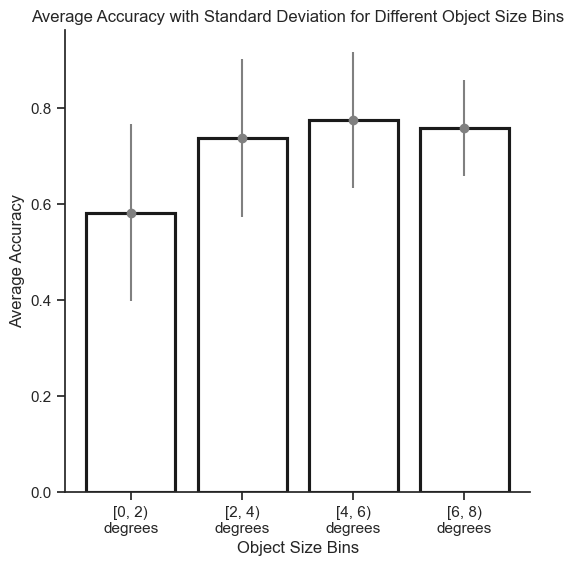

In [321]:
bins = [0, 2, 4, 6, 8]
df = pd.DataFrame(low_level_feats).drop(columns=['peak power'])#, 0,1,2,3])
df['humans']=beh_sig_sbj[signature]['humans']
df['monkeys']=beh_sig_sbj[signature]['pooled monkeys']
df['neurons']=full_decode_acc_models['Neural']
df['context type']=df.index%10
# Assign each object size to a bin
df['size_bin'] = pd.cut(df['object size']*(8/20), bins=bins, right=False)
df_long = pd.melt(df, id_vars=['size_bin'], value_vars=['humans', 'monkeys', 'neurons'],
                  var_name='Accuracy Type', value_name='Accuracy')

# Calculate the average accuracy for each size bin
avg_accuracy_per_bin = df.groupby('size_bin')['humans'].mean()
std_accuracy_per_bin = df.groupby('size_bin')['humans'].std()

# Combine the data into a DataFrame
plot_data = pd.DataFrame({'Size Bin': avg_accuracy_per_bin.index.astype(str)+'\ndegrees',
                          'Average Accuracy': avg_accuracy_per_bin.values,
                          'Standard Deviation': std_accuracy_per_bin.values})

# Plot the average accuracy with error bars for each size bin using Seaborn
sns.barplot(x='Size Bin', y='Average Accuracy', data=plot_data, fill=False,edgecolor='k')
plt.errorbar(x=plot_data['Size Bin'], y=plot_data['Average Accuracy'], yerr=plot_data['Standard Deviation'],fmt='o', c='grey')
plt.xlabel('Object Size Bins')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy with Standard Deviation for Different Object Size Bins')
sns.despine()
plt.show()


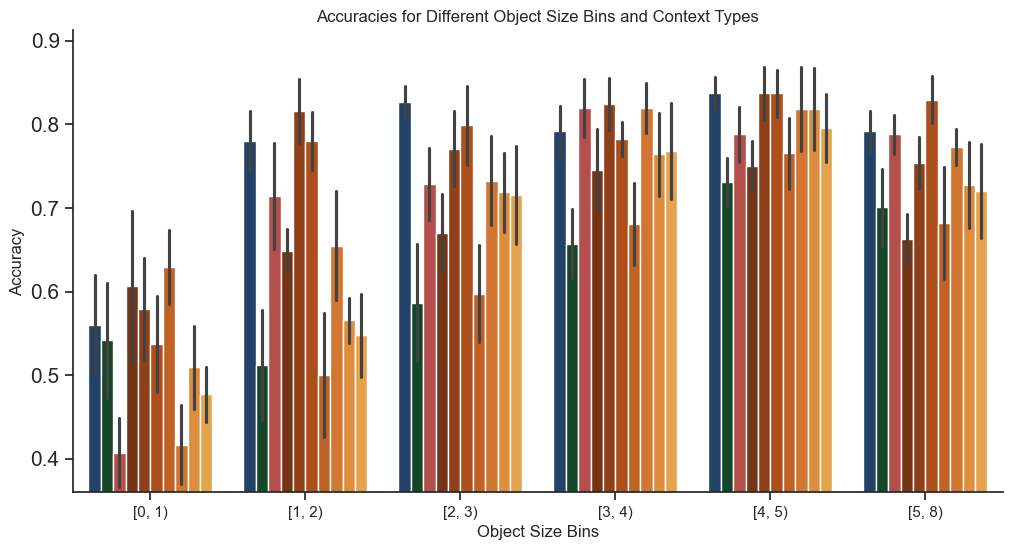

In [560]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df with columns 'object_size', 'accuracy_human', and 'context_type'
# Create bins for object sizes
bins = [0,1, 2,3, 4,5,8]
df = pd.DataFrame(low_level_feats).drop(columns=['peak power'])#, 0,1,2,3])
df['humans']=beh_sig_sbj[signature]['humans']
# Assign each object size to a bin
df['size_bin'] = pd.cut(df['object size']*(8/20), bins=bins, right=False)
df['context type']=df.index%10
# Plot the accuracies for different context types with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='size_bin', y='humans', hue='context type', data=df,legend=False, errorbar='se', palette=combined_palette)
plt.xlabel('Object Size Bins')
plt.ylabel('Accuracy')
plt.title('Accuracies for Different Object Size Bins and Context Types')
#plt.legend(title='Context Type', bbox_to_anchor=(1.05, 1), loc='upper left')
sns.despine()
plt.ylim(0.36)
plt.yticks(fontsize=15)
#plt.legend(frameon=False)

plt.savefig('object_size_all_context_humans.eps')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


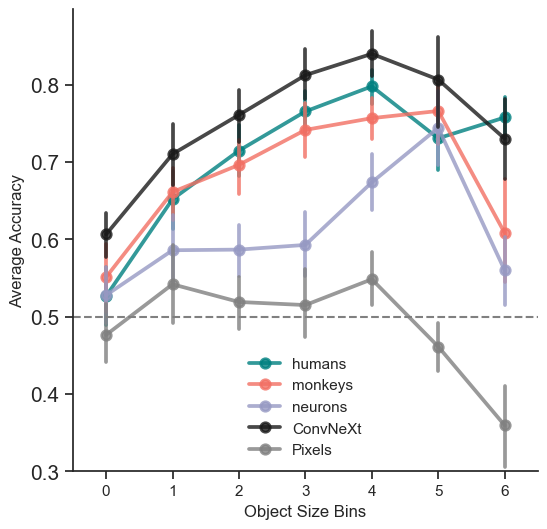

In [557]:
bins = [0,1, 2,3, 4,5,6,8]
df = pd.DataFrame(low_level_feats).drop(columns=['peak power'])#, 0,1,2,3])
df['humans']=beh_sig_sbj[signature]['humans']
df['monkeys']=beh_sig_sbj[signature]['pooled monkeys']
df['neurons']=full_decode_acc_models['Neural']
df['ConvNeXt']=full_decode_acc_models['ConvNeXt']
df['Pixels']=full_decode_acc_models['Pixels']

sns.set(rc={"figure.figsize":(6, 6), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 
df['context type']=df.index%10
# Assign each object size to a bin
df['size_bin'] = pd.cut(df['object size']*(8/20), bins=bins, right=False)
df['size_bin']=df['size_bin'].apply(lambda x:int(x.left))

df_long = pd.melt(df, id_vars=['size_bin'], value_vars=['humans', 'monkeys', 'neurons','ConvNeXt', 'Pixels'],
                  var_name='Accuracy Type', value_name='Accuracy')

sns.pointplot(x='size_bin', y='Accuracy', hue='Accuracy Type', data=df_long, alpha=0.8,
                #err_style='bars', 
              #markers=['<','>','o','*'],
             palette=['#008080', '#F26F63', '#9699C3', 'k','grey'])

plt.xlabel('Object Size Bins')
plt.ylabel('Average Accuracy')
sns.despine()
plt.ylim(0.3)
plt.axhline(y=0.5, linestyle='dashed', c='grey')
plt.legend(frameon=False)
plt.yticks(fontsize=15)
plt.savefig('object_size_all_models.eps')
plt.show()

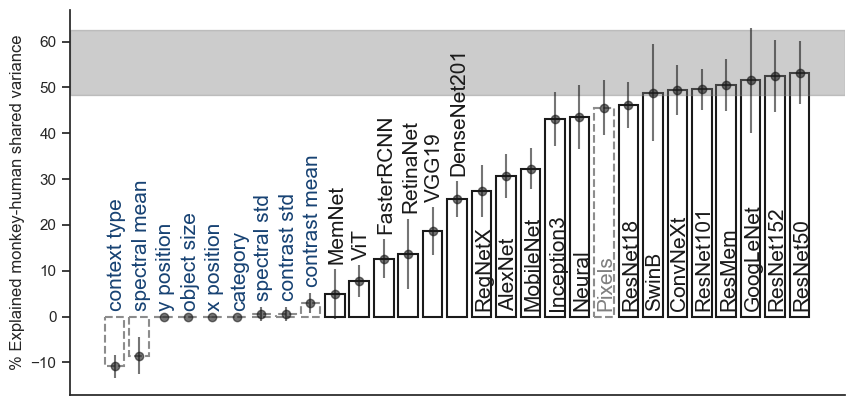

In [771]:
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']
signature='C1_subsamples'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])
mean = df.mean().sort_values()
std=df.std()[mean.index]
sns.set(rc={"figure.figsize":(10, 5), 'font.family':'arial', 'font.size': 8})
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)

df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
acc_models_df=pd.DataFrame(acc_models, index=[0]).T#.sort_values(by=0)#.reset_index()
acc_models_df[0]=scaler.fit_transform(acc_models_df)

df['acc']=acc_models_df#pd.DataFrame(acc_models, index=[0]).T.round(2)
color_mapping = sns.color_palette("Blues", as_cmap=True)
colors = [color_mapping(0 if pd.isna(acc) else 0.2 if acc ==0 else acc) for acc in df['acc']]
df['colors']=colors
df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df.loc[(pd.isna(df['acc'])), 'linestyle'] = 'dashed'  # Condition for red color

ax =sns.barplot(data=df, x=df.index, y='mean', linewidth=1.5,
                 fill=False, errorbar=None, edgecolor='k')#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
ax.errorbar(x=df.index.values, y=mean.values, yerr=std.values,fmt='o' , color='k', alpha=0.6)
ax.axhspan(ymin=mh_info[0]-mh_info[1],ymax=mh_info[0]+mh_info[1], label='human-monkey shared variance', alpha=0.4, color='gray')

plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()
# Setting the new ticks without changing labels
plt.xticks(rotation=45, ha='right') 
#
for i, bar in enumerate(ax.patches[:-1]):
    linestyle = df['linestyle'].iloc[i]
    bar.set_linestyle(linestyle)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    
plt.xlabel('')
xticks_labels =ax.get_xticklabels()
x_positions=np.sort([bar.get_x() for bar in ax.patches[:-1]])
for i, (p, l) in enumerate(zip(x_positions, xticks_labels)):
    model_=mean.index[i]
    #print(model_)
    color = '#174273' if model_ in low_level_feats.keys() else 'grey' if model_=='Pixels' else 'k'
    height=df.loc[mean.index[i]]['mean']+df.loc[mean.index[i]]['std'] + 2
    if (height >32.5)or  (height <0.5):
        height=2

    ax.text(x=l.get_position()[0]+0.09 , y= l.get_position()[1]+height,s=l.get_text(), ha='center', rotation=90, fontsize=15, color=color, alpha=0.6 if model_=='low-level features' else 1)
ax.set_xticklabels([])
ax.set_xticks([])


plt.savefig(f'{signature}_explained_neurons_llfeats_ceiling_bootstrap.pdf')

plt.show()

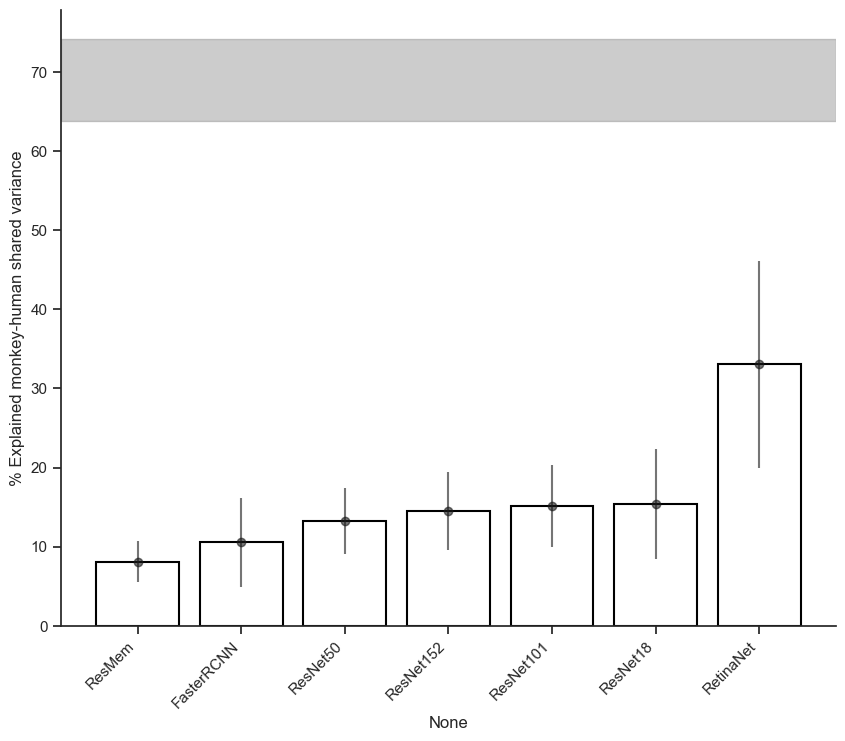

In [27]:

acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']

signature='O1'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])
df = df[['ResMem', 'ResNet101', 'ResNet18', 'ResNet50', 'ResNet152', 'FasterRCNN', 'RetinaNet']]


mean = df.mean().sort_values()
std=df.std()[mean.index]
sns.set(rc={"figure.figsize":(10, 8), 'font.family':'arial', 'font.size': 8})
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)


sns.set_theme(style="white")
sns.set_style('ticks') 
df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
acc_models_df=pd.DataFrame(acc_models, index=[0]).T#.sort_values(by=0)#.reset_index()
acc_models_df[0]=scaler.fit_transform(acc_models_df)

df['acc']=acc_models_df#pd.DataFrame(acc_models, index=[0]).T.round(2)
color_mapping = sns.color_palette("Blues", as_cmap=True)
colors = [color_mapping(0 if pd.isna(acc) else 0.2 if acc ==0 else acc) for acc in df['acc']]
df['colors']=colors
df['linestyle']='solid'

ax =sns.barplot(data=df, x=df.index, y='mean',  linewidth=1.5,fill=False,
                 errorbar=None,edgecolor="black")#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
ax.errorbar(x=df.index.values, y=mean.values, yerr=std.values,fmt='o' , color='k', alpha=0.6)
ax.axhspan(ymin=mh_info[0]-mh_info[1],ymax=mh_info[0]+mh_info[1], label='human-monkey shared variance', alpha=0.4, color='gray')


plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()
#plt.ylim(10,45)
# Setting the new ticks without changing labels
plt.xticks(rotation=45, ha='right') 
#

#df
for i, bar in enumerate(ax.patches[:-1]):
    linestyle = df['linestyle'].iloc[i]
    bar.set_linestyle(linestyle)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    


plt.show()

In [ ]:
def get_corr_with_hm(model_acc, signature, idx):
    model_trials= model_acc #if not neural else np.array([acc_neurons_subsb[key] for key in acc_neurons_subsb.keys()])
    if signature == 'C1_subsamples':
        df_human_monkey = pd.DataFrame((beh_sig_sbj['C1_subsamples'][x][idx],
                                        beh_sig_sbj['C1_subsamples'][y][idx])).T
        df_human_monkey.columns=[x,y]
        df_model=pd.DataFrame(model_trials).iloc[idx]
        df_both=pd.concat((df_human_monkey, df_model), axis=1)
        df_both.columns=[x,y,0]
        return df_both.corr()
    else:
        df_human_monkey=pd.DataFrame(beh_sig_sbj[signature])[[x,y]]
        #print(df_human_monkey.dropna())
        df_model=pd.DataFrame(model_trials)# if not neural else pd.DataFrame(model_trials[-1][-1])
        #print(df_model.dropna())
    return pd.concat((df_human_monkey, df_model), axis=1).loc[idx].corr(method='spearman')#[x][y]    



In [586]:

low_level_feats = pd.read_pickle('../../prediction_demo/monkey_data/low-level_features.pkl')
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates_all.pkl')
#{'I1':pd.read_pickle('asd_i1.pkl')}


import pingouin
from scipy.optimize import curve_fit
import sympy as sp
r_human, r_monkey=dict(), {}
splits=dict()
# subsample 300 images 20 times for the image-level analysis       
splits['I1']=nsplits=np.array([
[
    np.random.seed(seed), 
    np.random.permutation(NB_IMAGES)[:NB_IMAGES//2],
    np.random.seed(seed),
    np.random.permutation(NB_IMAGES)[NB_IMAGES//2:]
][1::2] # Extracting the results excluding the seed setting
for seed in range(10) 
]).reshape((20, 300))   


splits['C1_subsamples'] = list(range(10))#[[x for x in range(10) if x != seed] for seed in range(10)]
splits['I1n']=splits['I1']
splits['C1'] = [[x for x in range(10) if x != seed] for seed in range(10)]
splits['O1']=splits['C1']

full_decode_acc_models=pd.read_pickle('results/acc_all_models_3k_no_dd.pkl') 
llfeats_dict = dict(zip(low_level_feats.columns,low_level_feats.values.T))
full_decode_acc_models.update(llfeats_dict)
full_decode_acc_models['Neural']=pd.read_pickle(f'results/no_dd/acc_600_decoding_5f_122n_7_17_svm_pc_nodd.pkl')
#full_decode_acc_models['Neural extrapolated']=pd.read_pickle('results/acc_600_decoding_5f_122n_7_17_no_dd_splits.pkl')

band_mh=dict()
#all_trials=pd.read_pickle('results/all_trials_monkeys_humans.pkl')
for signature in [ 'C1_subsamples','C1','O1','I1', 'I1n']:
    x,y ='humans', 'pooled monkeys'
    #corr_mh = pd.DataFrame(beh_sig_sbj[signature])[[x,y]].corr()[x][y]/(self_consistency[x][signature][0]*self_consistency[y][signature][0])#self_consistency[y][signature][0])
    r_human[signature]=dict()
    r_monkey[signature]={}
    for model in full_decode_acc_models.keys():
        print(model)
        r_human[signature][model]=[]
        r_monkey[signature][model]=[]
        r_monkey[signature]['Humans']=[]
        r_human[signature]['Monkeys']=[]
        band_mh[signature]=[]
        for idx_subsample in splits[signature]:
            if signature=='C1_subsamples':
                corr_coef_mh = np.corrcoef(beh_sig_sbj['C1_subsamples'][x][idx_subsample], beh_sig_sbj['C1_subsamples'][y][idx_subsample])[0,1]
                corr_mh = corr_coef_mh
            else:
                corr_mh = pd.DataFrame(beh_sig_sbj[signature])[[x,y]].iloc[idx_subsample].corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])#self_consistency[y][signature][0])
            band_mh[signature].append(corr_mh)
            limits=[]
            acc_model=full_decode_acc_models[model]
            
            model_signature=get_beh_signatures_from_acc(acc_model)[signature]
            corr_all = get_corr_with_hm(model_signature, idx=idx_subsample,
                                      signature=signature)
            r_human[signature][model].append(corr_all['humans'][0]) #(corr_mh**2)
            r_monkey[signature][model].append(corr_all['pooled monkeys'][0])
            r_monkey[signature]['Humans'].append(corr_all['humans']['pooled monkeys'])
            r_human[signature]['Monkeys'].append(corr_all['humans']['pooled monkeys']) 

ResMem
Inception3
GoogLeNet
ResNet101
ResNet18
ResNet50
VGG19
AlexNet
DenseNet201
MobileNet
MemNet
ResNet152
Pixels
ViT
ConvNeXt
FasterRCNN
SwinB
RegNetX
RetinaNet
spectral mean
spectral std
peak power
category
x position
y position
contrast mean
contrast std
object size
context type
Neural
ResMem
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
          0
0  0.691108
1  0.596015
2  0.638672
3  0.585756
4  0.692912
5  0.678359
6  0.592742
7  0.673946
8  0.666366
9  0.668629
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.6986

     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
          0
0  0.735893
1  0.600924
2  0.738183
3  0.646373
4  0.736945
5  0.717096
6  0.595031
7  0.744891
8  0.696710
9  0.708540
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
          0
0  0.735893
1  0.600924
2  0.738183
3  0.646373
4  0.736945
5  0.717096
6  0.595031
7  0.744891
8  0.696710
9  0.708540
ResNet18
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182

     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
          0
0  0.747606
1  0.611295
2  0.741507
3  0.660072
4  0.754556
5  0.730414
6  0.604189
7  0.743577
8  0.711576
9  0.718544
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
          0
0  0.747606
1  0.611295
2  0.741507
3  0.660072
4  0.754556
5  0.730414
6  0.604189
7  0.743577
8  0.711576
9  0.718544
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684

     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
            0
0  239.158333
1  239.158333
2  239.158333
3  239.158333
4  239.158333
5  239.158333
6  239.158333
7  239.158333
8  239.158333
9  239.158333
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0.636364
2  0.716667        0.693182
3  0.684028        0.640152
4  0.765972        0.734848
5  0.764583        0.693939
6  0.652778        0.632576
7  0.713194        0.688636
8  0.698611        0.707576
9  0.681250        0.725000
            0
0  239.158333
1  239.158333
2  239.158333
3  239.158333
4  239.158333
5  239.158333
6  239.158333
7  239.158333
8  239.158333
9  239.158333
     humans  pooled monkeys
0  0.770833        0.726515
1  0.633333        0

     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.529903
1  0.787743
2  0.676172
3  0.641940
4  0.704299
5  0.668809
6  0.638107
7  0.794562
8  0.631357
9  0.571021
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.529903
1  0.787743
2  0.676172
3  0.641940
4  0.704299
5  0.668809
6  0.638107
7  0.794562
8  0.631357
9  0.571021
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745

     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.431923
1  0.582185
2  0.584365
3  0.544704
4  0.525703
5  0.543021
6  0.533001
7  0.593164
8  0.525425
9  0.470937
AlexNet
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.504135
1  0.648980
2  0.686750
3  0.721677
4  0.540550
5  0.594256
6  0.605536
7  0.673964
8  0.581107
9  0.403975
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909


     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.484178
1  0.607122
2  0.549723
3  0.564044
4  0.688265
5  0.358529
6  0.363571
7  0.617046
8  0.311249
9  0.661742
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
          0
0  0.484178
1  0.607122
2  0.549723
3  0.564044
4  0.688265
5  0.358529
6  0.363571
7  0.617046
8  0.311249
9  0.661742
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745

     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
              0
0  3.303497e+09
1  3.872985e+09
2  3.139932e+09
3  2.503366e+09
4  3.835831e+09
5  1.926891e+09
6  4.510458e+09
7  4.052371e+09
8  3.461553e+09
9  5.251423e+09
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
              0
0  3.303497e+09
1  3.872985e+09
2  3.139932e+09
3  2.503366e+09
4  3.835831e+09
5  1.926891e+09
6  4.510458e+09
7  4.052371e+09
8  3.461553e+09
9  5.251423e+09
     humans  pooled monkeys
0  0

     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
           0
0  46.761523
1  49.295113
2  42.593594
3  51.734668
4  46.395611
5  39.235155
6  54.823303
7  40.733899
8  43.026662
9  35.199365
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167        0.690909
3  0.745833        0.704545
4  0.725000        0.736364
5  0.737500        0.822727
6  0.645833        0.609091
7  0.841667        0.850000
8  0.629167        0.645455
9  0.695833        0.659091
           0
0  46.761523
1  49.295113
2  42.593594
3  51.734668
4  46.395611
5  39.235155
6  54.823303
7  40.733899
8  43.026662
9  35.199365
     humans  pooled monkeys
0  0.658333        0.527273
1  0.795833        0.763636
2  0.679167   

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.580674
1    0.525877
2    0.369129
3    0.644279
4    0.519870
..        ...
595  0.990596
596  0.975248
597  0.994688
598  0.954684
599  0.961581

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.580674
1    0.52587

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.652253
1    0.557838
2    0.399621
3    0.500083
4    0.540449
..        ...
595  0.984764
596  0.969000
597  0.998167
598  0.992866
599  0.962859

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.652253
1    0.55783

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.449675
1    0.371444
2    0.317647
3    0.560790
4    0.430907
..        ...
595  0.855956
596  0.622756
597  0.887854
598  0.718550
599  0.743425

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.449675
1    0.37144

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.742699
1    0.521601
2    0.413526
3    0.804092
4    0.694265
..        ...
595  0.878062
596  0.790520
597  0.967263
598  0.914975
599  0.809292

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.742699
1    0.52160

Pixels
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.726863
1    0.336980
2    0.226974
3    0.819103
4    0.746361
..        ...
595  0.463150
596  0.570005
597  0.494263
598  0.495868
599  0.558447

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.726863
1    

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.495015
1    0.563663
2    0.455152
3    0.684825
4    0.483404
..        ...
595  0.996384
596  0.993160
597  0.996919
598  0.993342
599  0.995921

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.495015
1    0.56366

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.803361
1    0.666071
2    0.582437
3    0.754706
4    0.647487
..        ...
595  0.997778
596  0.990384
597  0.996560
598  0.998316
599  0.996515

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.803361
1    0.66607

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.526781
1    0.446958
2    0.119629
3    0.520387
4    0.585406
..        ...
595  0.685244
596  0.718619
597  0.805196
598  0.533490
599  0.609624

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.526781
1    0.44695

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
             0
0    56.445056
1    52.983422
2    11.869273
3    54.576225
4    51.152174
..         ...
595  36.412418
596  51.690701
597  34.867740
598  47.772146
599  48.279201

[600 rows x 1 columns]
peak power
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
                0

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
         0
0    255.5
1    255.5
2    255.5
3    255.5
4    255.5
..     ...
595  256.0
596  256.0
597  256.0
598  256.0
599  256.0

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
         0
0    255.5
1    255.5
2    255.5
3    255.5
4    255.5
..     ...

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
             0
0    56.445056
1    52.983422
2    11.869273
3    54.576225
4    51.152174
..         ...
595  36.412418
596  51.690701
597  34.867740
598  47.772146
599  48.279201

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
             0
0    56.44505

       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.402333
1    0.425644
2    0.430072
3    0.460142
4    0.332684
..        ...
595  0.938933
596  0.940356
597  0.864853
598  0.878952
599  0.927147

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.791667        0.545455
1    0.416667        0.454545
2    0.750000        0.590909
3    0.541667        0.409091
4    0.708333        0.636364
..        ...             ...
595  0.958333        0.772727
596  0.958333        1.000000
597  0.875000        0.954545
598  1.000000        0.909091
599  0.875000        0.818182

[600 rows x 2 columns]
            0
0    0.402333
1    0.42564

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.137724
1   -0.050124
2   -0.328265
3    0.016138
4   -0.190697
..        ...
595  0.290594
596  0.401600
597  0.303610
598  0.290394
599  0.282358

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.137724
1   -0.05012

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.046912
1   -0.025782
2   -0.322358
3   -0.123395
4   -0.165438
..        ...
595  0.299258
596  0.390726
597  0.290875
598  0.317169
599  0.275806

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.046912
1   -0.02578

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.047066
1   -0.032346
2   -0.388729
3    0.007508
4   -0.133273
..        ...
595  0.364713
596  0.363595
597  0.308722
598  0.287775
599  0.244427

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.047066
1   -0.03234

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.123903
1    0.011088
2   -0.231167
3    0.220860
4    0.072438
..        ...
595  0.269421
596  0.280212
597  0.339895
598  0.268441
599  0.188411

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.123903
1    0.01108

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.008219
1    0.107373
2   -0.009391
3    0.045515
4    0.018765
..        ...
595  0.247715
596  0.357956
597  0.248153
598  0.269610
599  0.221408

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.008219
1    0.10737

ConvNeXt
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.319089
1   -0.074311
2   -0.384008
3   -0.038167
4   -0.333817
..        ...
595  0.198808
596  0.359284
597  0.204739
598  0.235889
599  0.227645

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.319089
1  

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.039026
1    0.100362
2   -0.144411
3    0.111612
4   -0.095259
..        ...
595  0.252280
596  0.427439
597  0.282851
598  0.298622
599  0.300392

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.039026
1    0.10036

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.042804
1   -0.015145
2   -0.381399
3    0.065784
4    0.101129
..        ...
595  0.202757
596  0.256374
597  0.299230
598  0.070870
599  0.118742

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.042804
1   -0.01514

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
             0
0     5.880156
1    -5.321939
2    -2.859461
3     6.047875
4     4.107851
..         ...
595 -13.646827
596  -6.492930
597  15.911923
598  -8.946572
599  -3.206389

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
             0
0     5.88015

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
       0
0   -2.5
1   -2.5
2   -2.5
3   -2.5
4   -2.5
..   ...
595  4.5
596  4.5
597  4.5
598  4.5
599  4.5

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
       0
0   -2.5
1   -2.5
2   -2.5
3   -2.5
4   -2.5
..   ...
595  4.5
596  4.5
597  4.5
598  4.5
5

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.010602
1    0.005328
2   -0.140116
3    0.015720
4   -0.027472
..        ...
595  0.012406
596  0.005716
597  0.047312
598  0.000000
599  0.009537

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0    0.010602
1    0.00532

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -3.283333
1   -3.283333
2   -3.283333
3   -3.283333
4   -3.283333
..        ...
595  5.716667
596  5.716667
597  5.716667
598  5.716667
599  5.716667

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -3.283333
1   -3.28333

       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.243810
1   -0.100030
2   -0.238348
3   -0.057657
4   -0.323738
..        ...
595  0.307263
596  0.404464
597  0.229626
598  0.237557
599  0.291079

[600 rows x 1 columns]
       humans  pooled monkeys
0    0.020833       -0.181061
1   -0.216667       -0.181818
2    0.033333       -0.102273
3   -0.142361       -0.231061
4   -0.057639       -0.098485
..        ...             ...
595  0.193750        0.078788
596  0.305556        0.367424
597  0.161806        0.265909
598  0.301389        0.201515
599  0.193750        0.093182

[600 rows x 2 columns]
            0
0   -0.243810
1   -0.10003

In [504]:
shc_neurons=pd.read_pickle('shc_7_17.pkl')
shc_neurons['I1'].mean(axis=1).std()
#pd.DataFrame(esv[signature]).drop(columns=['peak power'])['Neural']/np.sqrt(np.nanmean(shc_neurons[signature]))

0.021414357204975382

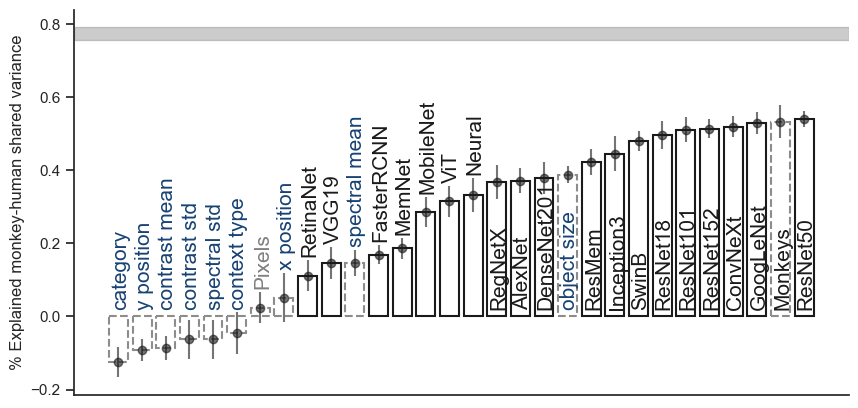

In [510]:
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']
esv=r_human
signature='I1'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])
df['Monkeys']=df['Monkeys']/self_consistency['pooled monkeys'][signature][0]
df['Neural']=df['Neural']/np.sqrt(np.nanmean(shc_neurons['I1' if signature=='I1n' else signature + '_decode']))
df['Neural']=np.clip(df['Neural'], None, 1)
mean = df.mean().sort_values()
std=df.std()[mean.index]
sns.set(rc={"figure.figsize":(10, 5), 'font.family':'arial', 'font.size': 8})
mh_info = distribution_info(np.array(self_consistency['humans']['C1' if signature=='C1_subsamples' else signature][4])**2)#distribution_info((self_consistency['humans']**2)*100)


sns.set_theme(style="white")
sns.set_style('ticks') 
df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
acc_models_df=pd.DataFrame(acc_models, index=[0]).T#.sort_values(by=0)#.reset_index()
acc_models_df[0]=scaler.fit_transform(acc_models_df)

df['acc']=acc_models_df#pd.DataFrame(acc_models, index=[0]).T.round(2)
color_mapping = sns.color_palette("Blues", as_cmap=True)
colors = [color_mapping(0 if pd.isna(acc) else 0.2 if acc ==0 else acc) for acc in df['acc']]
df['colors']=colors
df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df.loc[(pd.isna(df['acc'])), 'linestyle'] = 'dashed'  # Condition for red color

ax =sns.barplot(data=df, x=df.index, y='mean', linewidth=1.5,
                 fill=False, errorbar=None, edgecolor='k')#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
ax.errorbar(x=df.index.values, y=mean.values, yerr=std.values,fmt='o' , color='k', alpha=0.6)
ax.axhspan(ymin=mh_info[2],ymax=mh_info[3], label='human-monkey shared variance', alpha=0.4, color='gray')



plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()

plt.xticks(rotation=45, ha='right') 

for i, bar in enumerate(ax.patches[:-1]):
    linestyle = df['linestyle'].iloc[i]
    bar.set_linestyle(linestyle)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    bar.set_alpha(0.5 if linestyle=='dashed' else 1)
    
plt.xlabel('')
#ax = plt.gca()
xticks_labels =ax.get_xticklabels()# [label.get_text() for label in ax.get_xticklabels()]

x_positions=np.sort([bar.get_x() for bar in ax.patches[:-1]])
for i, (p, l) in enumerate(zip(x_positions, xticks_labels)):
    model_=mean.index[i]
    #print(model_)
    color = '#174273' if model_ in low_level_feats.keys() else 'grey' if model_=='Pixels' else 'k'
    height=df.loc[mean.index[i]]['mean']+df.loc[mean.index[i]]['std'] + 0.02
    #print(height)
    if (height >0.4) or (height<=0.05):
        height=0.03
    ax.text(x=l.get_position()[0]+0.09 , y= l.get_position()[1]+height,s=l.get_text(), ha='center', rotation=90, fontsize=15, color=color, alpha=0.6 if model_=='low-level features' else 1)
    #print(l)
ax.set_xticklabels([])
ax.set_xticks([])


plt.show()

In [199]:
df['acc']=pd.DataFrame(acc_models, index=['acc']).T
df['acc']

context type          NaN
Pixels           0.502935
contrast mean         NaN
x position            NaN
spectral std          NaN
contrast std          NaN
spectral mean         NaN
y position            NaN
RetinaNet        0.479019
category              NaN
VGG19            0.536966
FasterRCNN       0.522349
MemNet           0.531875
object size           NaN
MobileNet        0.599279
Neural           0.609471
ViT              0.546501
RegNetX          0.599182
DenseNet201      0.599935
AlexNet          0.604451
ResMem           0.648451
Inception3       0.670703
ResNet101        0.692059
ResNet18         0.666795
SwinB            0.686070
ResNet152        0.702334
ResNet50         0.684891
GoogLeNet        0.663874
ConvNeXt         0.758081
Name: acc, dtype: float64

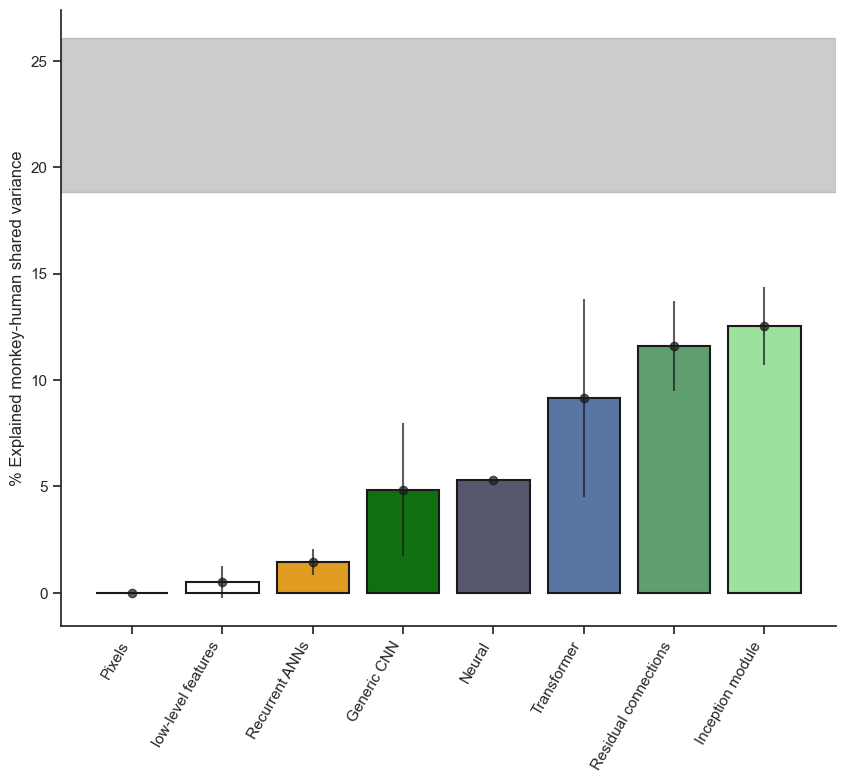

In [201]:


color_map={'low-level features':'w','Memorability':'r','Neural':'#545570', 'Inception module':'lightgreen', 'Generic CNN':'green', 'Residual connections':sns.palettes.color_palette()[2], 'Pixels':'k', 'Transformer':'b', 'Recurrent ANNs':'orange'}
#signature='C1'
#full_decode_acc_models['Neural extrapolated']=full_decode_acc_models['Neural']
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from sklearn.preprocessing import MinMaxScaler
sns.set(rc={"figure.figsize":(10, 8), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 

%matplotlib inline
signature='I1'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])

mean = df.mean().sort_values()
std=df.std()[mean.index]
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)
df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
df['acc']=pd.DataFrame(acc_models, index=['acc']).T


df['Group'] = df.index.map(model_groups)
df['Group'].fillna('low-level features', inplace=True)
#df=df.sort_values(['Group', 'mean'], ascending=[False, True])

df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df['colors'] = df['Group'].map(color_map)
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color

df_grouped=df.groupby('Group').aggregate(np.mean)#.sort_values('mean')
df_grouped['std']=df.groupby('Group').aggregate(np.nanstd)['mean']
#g = sns.JointGrid(height=16, ratio=6)
df_grouped=df_grouped.sort_values('mean')
ax =sns.barplot(data=df_grouped, x=df_grouped.index, y='mean', linewidth=1.5, palette=color_map,
                 fill=True, errorbar=None, edgecolor='k',hue='Group', estimator='mean', legend=False)#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
ax.errorbar(x=df_grouped.index.values, y=df_grouped['mean'], yerr=df_grouped['std'],fmt='o' , color='k', alpha=0.7)
ax.axhspan(ymin=mh_info[0]-mh_info[1],ymax=mh_info[0]+mh_info[1],  alpha=0.4, color='gray')



plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()
#plt.ylim(10,45)
# Setting the new ticks without changing labels
plt.xticks(rotation=60, ha='right') 
#

#df

#plt.legend(frameon=False, title='Model architecture')
plt.xlabel('')
ax = plt.gca()
xticks_labels =ax.get_xticklabels()# [label.get_text() for label in ax.get_xticklabels()]


#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#for i, (p, l) in enumerate(zip(ax.patches, xticks_labels)):
#ax.set_xticklabels([])
#ax.set_xticks([])
plt.savefig(f'{signature}_grouped_models.pdf')
plt.show()

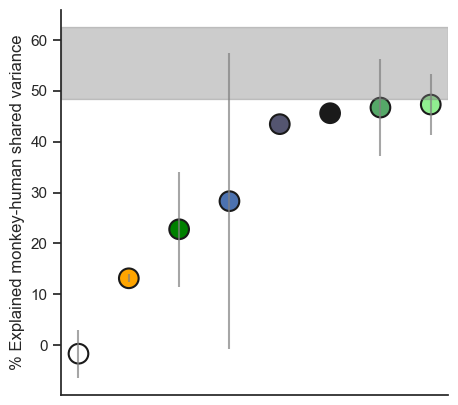

In [272]:


color_map={'low-level features':'w','Memorability':'r','Neural':'#545570', 'Inception module':'lightgreen', 'Generic CNN':'green', 'Residual connections':sns.palettes.color_palette()[2], 'Pixels':'k', 'Transformer':'b', 'Recurrent ANNs':'orange'}
#signature='C1'
#full_decode_acc_models['Neural extrapolated']=full_decode_acc_models['Neural']
acc_models=dict([(model, full_decode_acc_models[model].mean() if model not in low_level_feats else np.nan) for model in full_decode_acc_models.keys()])
del acc_models['peak power']
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
from sklearn.preprocessing import MinMaxScaler
sns.set(rc={"figure.figsize":(5, 5), 'font.family':'arial', 'font.size': 8})
sns.set_theme(style="white")
sns.set_style('ticks') 

%matplotlib inline
signature='C1_subsamples'
scaler=MinMaxScaler()
font = fm.FontProperties(family = 'arial')
df = pd.DataFrame(esv[signature]).drop(columns=['peak power'])#, 0,1,2,3])

mean = df.mean().sort_values()
std=df.std()[mean.index]
mh_info = distribution_info((np.array(band_mh[signature])**2)*100)
df =pd.DataFrame(mean, columns=['mean'])
df['std']=std
df['Group'] = df.index.map(model_groups)
df['Group'].fillna('low-level features', inplace=True)
#df=df.sort_values(['Group', 'mean'], ascending=[False, True])

df['linestyle']='solid'
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color
df['colors'] = df['Group'].map(color_map)
df.loc['Pixels', 'linestyle'] = 'dashed'  # Condition for red color

df_grouped=df.groupby('Group').aggregate(np.mean)#.sort_values('mean')
df_grouped['std']=df.groupby('Group').aggregate(np.nanstd)['mean']
#g = sns.JointGrid(height=16, ratio=6)
df_grouped=df_grouped.sort_values('mean')

d=df.groupby('Group').aggregate(lambda x: [x.values])['mean'].apply(lambda x: x[0])


ax =sns.scatterplot(data=df_grouped, x=df_grouped.index, y='mean', linewidth=1.5, palette=color_map,
                  hue='Group', legend=False, s=200, edgecolor='k')#,ax=g.ax_joint)#model_color_dict)#error_kw={'ecolor': 'r', 'alpha':0.3, 'yerr':df_all_std.values.flatten()}
ax.errorbar(x=df_grouped.index, y=df_grouped['mean'], yerr=df_grouped['std'],fmt='None' ,c='grey',  alpha=0.7)

ax.axhspan(ymin=mh_info[0]-mh_info[1],ymax=mh_info[0]+mh_info[1],  alpha=0.4, color='gray')



plt.ylabel('% Explained monkey-human shared variance',fontproperties = font)
sns.despine()
#plt.ylim(10,45)
# Setting the new ticks without changing labels
plt.xticks(rotation=60, ha='right') 
#

#df

#plt.legend(frameon=False, title='Model architecture')
plt.xlabel('')
ax = plt.gca()
xticks_labels =ax.get_xticklabels()# [label.get_text() for label in ax.get_xticklabels()]


#ax.yaxis.set_major_locator(MultipleLocator(0.1))
#for i, (p, l) in enumerate(zip(ax.patches, xticks_labels)):
ax.set_xticklabels([])
ax.set_xticks([])
plt.savefig(f'{signature}_grouped_models.pdf')
plt.show()

In [672]:
color_map.keys()
sorted_groups=['low-level features','Pixels',  'Neural','Recurrent ANNs', 'Transformer',
 
  'Generic CNN','Inception module', 'Residual connections' 
]
df_grouped

,mean,std
Group,,
Generic CNN,42.129859,20.633068
Inception module,85.610622,9.191696
Neural,79.572974,NaN
Pixels,82.618610,NaN
Recurrent ANNs,23.351985,1.094641
Residual connections,85.051501,16.879126
Transformer,50.896713,51.745515
low-level features,-3.071538,8.721485


# Within context type

In [381]:

low_level_feats = pd.read_pickle('../../prediction_demo/monkey_data/low-level_features.pkl')

valid_trials=pd.read_pickle('results/valid_trials_per_sbj.pkl')
import pingouin
from scipy.optimize import curve_fit
import sympy as sp
esv=dict()
splits=dict()
# subsample 300 images 20 times for the image-level analysis       
beh_sig_sbj=pd.read_pickle('results/behavioral_signatures_primates.pkl')#{'I1':pd.read_pickle('asd_i1.pkl')}


# for C1 use leave one out for subsampling
context_grouped_images=[list(range(i, NB_IMAGES, NB_CONTEXT_TYPES)) for i in range(NB_CONTEXT_TYPES)]
splits=[np.array([
[
    np.random.seed(seed), 
    np.random.choice(context_grouped_images[context_type], 60),
][1] # Extracting the results excluding the seed setting
for seed in range(10) 
]).reshape((10, 60))  for context_type in range(10)]


full_decode_acc_models=pd.read_pickle('results/acc_all_models_3k_no_dd.pkl') 
llfeats_dict = dict(zip(low_level_feats.columns,low_level_feats.values.T))
full_decode_acc_models.update(llfeats_dict)
full_decode_acc_models['Neural']=pd.read_pickle(f'results/no_dd/acc_600_decoding_5f_122n_7_17_svm_pc_nodd.pkl')
#full_decode_acc_models['Neural extrapolated']=pd.read_pickle('results/acc_600_decoding_5f_122n_7_17_no_dd_splits.pkl')

band_mh=dict()
band_mh_corrected=dict()
for context_type in range(10):
    x,y ='humans', 'mean monkeys'
    #corr_mh = pd.DataFrame(beh_sig_sbj[signature])[[x,y]].corr()[x][y]/(self_consistency[x][signature][0]*self_consistency[y][signature][0])#self_consistency[y][signature][0])
    esv[context_type]=dict()
    band_mh_corrected[context_type]=dict()
    for model in full_decode_acc_models.keys():
        #print(model)
        esv[context_type][model]=[]
        band_mh[context_type]=[]
        #band_mh_corrected[context_type]=[]
        #idx_subsample= splits[context_type]
        for idx_subsample in splits[context_type]:
            print(idx_subsample)
            corr_mh = pd.DataFrame(beh_sig_sbj['I1'])[[x,y]].iloc[idx_subsample].corr()[x][y]#/(self_consistency[x][signature][0]*self_consistency[y][signature][0])#self_consistency[y][signature][0])
            band_mh[context_type].append(corr_mh)
            #sc_h = get_splithalf_corr_subsample(valid_trials['Bento'][:,:-1],idx_subsample, 100 )
            #sc_m = get_splithalf_corr_subsample(valid_trials['Magneto'][:,:-1],idx_subsample, 100 )
            #band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))
            limits=[]
            acc_model=full_decode_acc_models[model]

            model_signature=get_beh_signatures_from_acc(acc_model)['I1']


[440 470 530   0  30 590  30 390  90 190 210 500 360 230  60 240 240 120
 580  10 380 390 230 460 240 170 370 250 130  80  90 200 510 160 510  50
 150 470   0 180 350 240 490 510 290 190 190 140 390 320  10  90 570 320
 310 100 520 230 350 110]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6025 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150   0 160  10 120  70 450  60 250 500 200
 370 180 200 110 420 280 290 140 500  40 230 230 410 490 550 300 320 220
 130 410  90  70 220 570  10   0 170  80 240 130 510 470 420 570  80 300
  70  30  60 210 490 570]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4147 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6793 
[400 150 450  80 220 430 180 110 400  70 340 490 310 110 210 470 310 260
 200 520 370 390  30 

Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 520 590 400 580 490 560 530 270 330 290
 280   0 460 590 240 100 560 290 420 560 120 180 220 560  10 560 350 110
 370 190 380 550  90 160 560 490 400 130 590 580 330 130 290 440 580 540
 220 500 400  40 530 350]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6815 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  90 190 210 500 360 230  60 240 240 120
 580  10 380 390 230 460 240 170 370 250 130  80  90 200 510 160 510  50
 150 470   0 180 350 240 490 510 290 190 190 140 390 320  10  90 570 320
 310 100 520 230 350 110]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6025 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150  

Average split-half correlation across 100 seeds I1: 0.4513 
[ 30 200 490 410  50 260  80 190 400 480 450 210 490 510 100 270 440 130
  90 150 290 340 590 180 140 380 290 560  90 510  40 530 530  70 590 420
 410 260  20 380  90 370 460 170 430 150 280 270 430 220 310 200 450 210
  80 280 280 310 470 100]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5631 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 520 590 400 580 490 560 530 270 330 290
 280   0 460 590 240 100 560 290 420 560 120 180 220 560  10 560 350 110
 370 190 380 550  90 160 560 490 400 130 590 580 330 130 290 440 580 540
 220 500 400  40 530 350]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6815 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  

Average split-half correlation across 100 seeds I1: 0.6331 
[470  40 250 540  30 190 230 390 280 570 140 230  80 250 460 420 260  80
 390 380  40 480  70 440   0 110 550 580  60 190 440  50 560 240 550 530
 480 590   0 340 560  90 140 380  40 460  90 230 350  30  80 190 480  10
   0 160 540 310 290 440]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6281 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4513 
[ 30 200 490 410  50 260  80 190 400 480 450 210 490 510 100 270 440 130
  90 150 290 340 590 180 140 380 290 560  90 510  40 530 530  70 590 420
 410 260  20 380  90 370 460 170 430 150 280 270 430 220 310 200 450 210
  80 280 280 310 470 100]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5631 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 5

Average split-half correlation across 100 seeds I1: 0.4147 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6793 
[400 150 450  80 220 430 180 110 400  70 340 490 310 110 210 470 310 260
 200 520 370 390  30 380  40 420 430 510 390 380 420 330 580  30  50 240
  40 460  60 310 190 570 310  20 160 520 460 120 500  40 260 150 490 390
 460  80 500 450 580 150]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6314 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6062 
[420 240 570  30 560  80   0 210 190 100 430 570 410 100 210 550 380 320
 200 440 290 390 140 560 260 170 260 220  20  20  10 510 260  50 400 460
 330 290 420 240 590  70 560 430 330 590 150 480 370 200 300 490 210 140
 520 280 550 540   0   0]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6132 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  90 190 210 500 360 230  60 240 240 120
 580  10 380 390 230 460 240 170 370 250 130  80  90 200 510 160 510  50
 150 470   0 180 350 240 490 510 290 190 190 140 390 320  10  90 570 320
 310 100 520 230 350 110]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6025 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150   0 160  10 120  70 450  60 250 500 200
 370 180 200 110 420 280 290 140 500  40 230 230 410 490 550 300 320 220
 130 410  90  70 220 570  10   0 170  80 240 130 510 470 420 570  80 300
  70  30  60 210 490 570]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4147 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6793 
[400 150 450  80 220 430 180 110 4

Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 520 590 400 580 490 560 530 270 330 290
 280   0 460 590 240 100 560 290 420 560 120 180 220 560  10 560 350 110
 370 190 380 550  90 160 560 490 400 130 590 580 330 130 290 440 580 540
 220 500 400  40 530 350]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6815 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  90 190 210 500 360 230  60 240 240 120
 580  10 380 390 230 460 240 170 370 250 130  80  90 200 510 160 510  50
 150 470   0 180 350 240 490 510 290 190 190 140 390 320  10  90 570 320
 310 100 520 230 350 110]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6025 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150  

Average split-half correlation across 100 seeds I1: 0.4513 
[ 30 200 490 410  50 260  80 190 400 480 450 210 490 510 100 270 440 130
  90 150 290 340 590 180 140 380 290 560  90 510  40 530 530  70 590 420
 410 260  20 380  90 370 460 170 430 150 280 270 430 220 310 200 450 210
  80 280 280 310 470 100]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5631 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 520 590 400 580 490 560 530 270 330 290
 280   0 460 590 240 100 560 290 420 560 120 180 220 560  10 560 350 110
 370 190 380 550  90 160 560 490 400 130 590 580 330 130 290 440 580 540
 220 500 400  40 530 350]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6815 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  

Average split-half correlation across 100 seeds I1: 0.6281 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4513 
[ 30 200 490 410  50 260  80 190 400 480 450 210 490 510 100 270 440 130
  90 150 290 340 590 180 140 380 290 560  90 510  40 530 530  70 590 420
 410 260  20 380  90 370 460 170 430 150 280 270 430 220 310 200 450 210
  80 280 280 310 470 100]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5631 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5101 
[280 530 540 560 590 220  10 220 520 590 400 580 490 560 530 270 330 290
 280   0 460 590 240 100 560 290 420 560 120 180 220 560  10 560 350 110
 370 190 380 550  90 160 560 490 400 130 590 580 330 130 290 440 580 540
 220 500 400  40 530 350]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6815 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4937 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6331 
[470  40 250 540  30 190 230 390 280 570 140 230  80 250 460 420 260  80
 390 380  40 480  70 440   0 110 550 580  60 190 440  50 560 240 550 530
 480 590   0 340 560  90 140 380  40 460  90 230 350  30  80 190 480  10
   0 160 540 310 290 440]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6281 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4513 
[ 30 200 490 410  50 260  80 190 400 480 450 210 490 510 100 270 440 130
  90 150 290 340 590 180 140 380 290 560  90 510  40 530 530  70 590 420
 410 260  20 380  90 370 460 170 430 150 280 270 430 220 310 200 450 210
  80 280 280 310 470 100]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5631 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4612 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7626 
[100  90 350 200 420 450 150 420 160 250  10 110 130 570 260 470 330 440
 460  40 330  80  20 120 200 270 310  20  50 260 150 250 220 500 430  50
 370 490  40 370 160  20  20 190 210 280 430 570  50 500 260 140 550 400
  50  60 420 260 100  30]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4937 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6331 
[470  40 250 540  30 190 230 390 280 570 140 230  80 250 460 420 260  80
 390 380  40 480  70 440   0 110 550 580  60 190 440  50 560 240 550 530
 480 590   0 340 560  90 140 380  40 460  90 230 350  30  80 190 480  10
   0 160 540 310 290 440]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6281 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4296 
[580 460 550  50  10 400 230  80 500  90 580 390 450 300 550 550 570 400
 360 500 440 380 420 520  30   0 550 210 210  90 380 380 560  20 460 530
 300  80 490  20 580 230 320 400 510 420 450 330 320 450 280  30 500 510
 150 340 310 570 500 170]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5255 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5321 
[350 140 470 380 540 160  90  80 360 390 270 480 300 160  70 120 150 490
 530 390 160 270 440 130 110  10 470 300 200 220 180 570  90 420 410 410
  10 180 390 160 140  50 580   0 160  40 460 360 410 510 270 310  20  40
 380 410 190 190 180 490]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4612 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7626 
[100  90 350 200 420 450 150 420 1

Average split-half correlation across 100 seeds I1: 0.6062 
[420 240 570  30 560  80   0 210 190 100 430 570 410 100 210 550 380 320
 200 440 290 390 140 560 260 170 260 220  20  20  10 510 260  50 400 460
 330 290 420 240 590  70 560 430 330 590 150 480 370 200 300 490 210 140
 520 280 550 540   0   0]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6132 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4296 
[580 460 550  50  10 400 230  80 500  90 580 390 450 300 550 550 570 400
 360 500 440 380 420 520  30   0 550 210 210  90 380 380 560  20 460 530
 300  80 490  20 580 230 320 400 510 420 450 330 320 450 280  30 500 510
 150 340 310 570 500 170]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5255 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5321 
[350 140 470 380 540 160  90  80 3

Average split-half correlation across 100 seeds I1: 0.6314 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6062 
[420 240 570  30 560  80   0 210 190 100 430 570 410 100 210 550 380 320
 200 440 290 390 140 560 260 170 260 220  20  20  10 510 260  50 400 460
 330 290 420 240 590  70 560 430 330 590 150 480 370 200 300 490 210 140
 520 280 550 540   0   0]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6132 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4296 
[580 460 550  50  10 400 230  80 500  90 580 390 450 300 550 550 570 400
 360 500 440 380 420 520  30   0 550 210 210  90 380 380 560  20 460 530
 300  80 490  20 580 230 320 400 510 420 450 330 320 450 280  30 500 510
 150 340 310 570 500 170]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5255 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150   0 160  10 120  70 450  60 250 500 200
 370 180 200 110 420 280 290 140 500  40 230 230 410 490 550 300 320 220
 130 410  90  70 220 570  10   0 170  80 240 130 510 470 420 570  80 300
  70  30  60 210 490 570]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4147 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6793 
[400 150 450  80 220 430 180 110 400  70 340 490 310 110 210 470 310 260
 200 520 370 390  30 380  40 420 430 510 390 380 420 330 580  30  50 240
  40 460  60 310 190 570 310  20 160 520 460 120 500  40 260 150 490 390
 460  80 500 450 580 150]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6314 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6062 
[420 240 570  30 560  80   0 210 1

Average split-half correlation across 100 seeds I1: 0.6263 
[440 470 530   0  30 590  30 390  90 190 210 500 360 230  60 240 240 120
 580  10 380 390 230 460 240 170 370 250 130  80  90 200 510 160 510  50
 150 470   0 180 350 240 490 510 290 190 190 140 390 320  10  90 570 320
 310 100 520 230 350 110]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6025 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5733 
[370 430 120  80  90 110  50 150   0 160  10 120  70 450  60 250 500 200
 370 180 200 110 420 280 290 140 500  40 230 230 410 490 550 300 320 220
 130 410  90  70 220 570  10   0 170  80 240 130 510 470 420 570  80 300
  70  30  60 210 490 570]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4147 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6793 
[400 150 450  80 220 430 180 110 4

Average split-half correlation across 100 seeds I1: 0.1132 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6587 
[441 471 531   1  31 591  31 391  91 191 211 501 361 231  61 241 241 121
 581  11 381 391 231 461 241 171 371 251 131  81  91 201 511 161 511  51
 151 471   1 181 351 241 491 511 291 191 191 141 391 321  11  91 571 321
 311 101 521 231 351 111]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5532 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7302 
[371 431 121  81  91 111  51 151   1 161  11 121  71 451  61 251 501 201
 371 181 201 111 421 281 291 141 501  41 231 231 411 491 551 301 321 221
 131 411  91  71 221 571  11   1 171  81 241 131 511 471 421 571  81 301
  71  31  61 211 491 571]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2255 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6756 
[ 31 201 491 411  51 261  81 191 401 481 451 211 491 511 101 271 441 131
  91 151 291 341 591 181 141 381 291 561  91 511  41 531 531  71 591 421
 411 261  21 381  91 371 461 171 431 151 281 271 431 221 311 201 451 211
  81 281 281 311 471 101]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3088 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7174 
[281 531 541 561 591 221  11 221 521 591 401 581 491 561 531 271 331 291
 281   1 461 591 241 101 561 291 421 561 121 181 221 561  11 561 351 111
 371 191 381 551  91 161 561 491 401 131 591 581 331 131 291 441 581 541
 221 501 401  41 531 351]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.1132 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6587 
[441 471 531   1  31 591  31 391  

Average split-half correlation across 100 seeds I1: 0.5490 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6756 
[ 31 201 491 411  51 261  81 191 401 481 451 211 491 511 101 271 441 131
  91 151 291 341 591 181 141 381 291 561  91 511  41 531 531  71 591 421
 411 261  21 381  91 371 461 171 431 151 281 271 431 221 311 201 451 211
  81 281 281 311 471 101]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3088 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7174 
[281 531 541 561 591 221  11 221 521 591 401 581 491 561 531 271 331 291
 281   1 461 591 241 101 561 291 421 561 121 181 221 561  11 561 351 111
 371 191 381 551  91 161 561 491 401 131 591 581 331 131 291 441 581 541
 221 501 401  41 531 351]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.1132 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6456 
[471  41 251 541  31 191 231 391 281 571 141 231  81 251 461 421 261  81
 391 381  41 481  71 441   1 111 551 581  61 191 441  51 561 241 551 531
 481 591   1 341 561  91 141 381  41 461  91 231 351  31  81 191 481  11
   1 161 541 311 291 441]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5490 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6756 
[ 31 201 491 411  51 261  81 191 401 481 451 211 491 511 101 271 441 131
  91 151 291 341 591 181 141 381 291 561  91 511  41 531 531  71 591 421
 411 261  21 381  91 371 461 171 431 151 281 271 431 221 311 201 451 211
  81 281 281 311 471 101]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3088 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7174 
[281 531 541 561 591 221  11 221 5

Average split-half correlation across 100 seeds I1: 0.3701 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6456 
[471  41 251 541  31 191 231 391 281 571 141 231  81 251 461 421 261  81
 391 381  41 481  71 441   1 111 551 581  61 191 441  51 561 241 551 531
 481 591   1 341 561  91 141 381  41 461  91 231 351  31  81 191 481  11
   1 161 541 311 291 441]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5490 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6756 
[ 31 201 491 411  51 261  81 191 401 481 451 211 491 511 101 271 441 131
  91 151 291 341 591 181 141 381 291 561  91 511  41 531 531  71 591 421
 411 261  21 381  91 371 461 171 431 151 281 271 431 221 311 201 451 211
  81 281 281 311 471 101]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3088 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.8100 
[101  91 351 201 421 451 151 421 161 251  11 111 131 571 261 471 331 441
 461  41 331  81  21 121 201 271 311  21  51 261 151 251 221 501 431  51
 371 491  41 371 161  21  21 191 211 281 431 571  51 501 261 141 551 401
  51  61 421 261 101  31]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3701 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6456 
[471  41 251 541  31 191 231 391 281 571 141 231  81 251 461 421 261  81
 391 381  41 481  71 441   1 111 551 581  61 191 441  51 561 241 551 531
 481 591   1 341 561  91 141 381  41 461  91 231 351  31  81 191 481  11
   1 161 541 311 291 441]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5490 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6756 
[ 31 201 491 411  51 261  81 191 4

Average split-half correlation across 100 seeds I1: 0.4090 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8100 
[101  91 351 201 421 451 151 421 161 251  11 111 131 571 261 471 331 441
 461  41 331  81  21 121 201 271 311  21  51 261 151 251 221 501 431  51
 371 491  41 371 161  21  21 191 211 281 431 571  51 501 261 141 551 401
  51  61 421 261 101  31]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3701 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6456 
[471  41 251 541  31 191 231 391 281 571 141 231  81 251 461 421 261  81
 391 381  41 481  71 441   1 111 551 581  61 191 441  51 561 241 551 531
 481 591   1 341 561  91 141 381  41 461  91 231 351  31  81 191 481  11
   1 161 541 311 291 441]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5490 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7030 
[351 141 471 381 541 161  91  81 361 391 271 481 301 161  71 121 151 491
 531 391 161 271 441 131 111  11 471 301 201 221 181 571  91 421 411 411
  11 181 391 161 141  51 581   1 161  41 461 361 411 511 271 311  21  41
 381 411 191 191 181 491]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4090 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8100 
[101  91 351 201 421 451 151 421 161 251  11 111 131 571 261 471 331 441
 461  41 331  81  21 121 201 271 311  21  51 261 151 251 221 501 431  51
 371 491  41 371 161  21  21 191 211 281 431 571  51 501 261 141 551 401
  51  61 421 261 101  31]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3701 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6456 
[471  41 251 541  31 191 231 391 2

Average split-half correlation across 100 seeds I1: 0.6544 
[581 461 551  51  11 401 231  81 501  91 581 391 451 301 551 551 571 401
 361 501 441 381 421 521  31   1 551 211 211  91 381 381 561  21 461 531
 301  81 491  21 581 231 321 401 511 421 451 331 321 451 281  31 501 511
 151 341 311 571 501 171]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3253 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7030 
[351 141 471 381 541 161  91  81 361 391 271 481 301 161  71 121 151 491
 531 391 161 271 441 131 111  11 471 301 201 221 181 571  91 421 411 411
  11 181 391 161 141  51 581   1 161  41 461 361 411 511 271 311  21  41
 381 411 191 191 181 491]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4090 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8100 
[101  91 351 201 421 451 151 421 1

Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6544 
[581 461 551  51  11 401 231  81 501  91 581 391 451 301 551 551 571 401
 361 501 441 381 421 521  31   1 551 211 211  91 381 381 561  21 461 531
 301  81 491  21 581 231 321 401 511 421 451 331 321 451 281  31 501 511
 151 341 311 571 501 171]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3253 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7030 
[351 141 471 381 541 161  91  81 361 391 271 481 301 161  71 121 151 491
 531 391 161 271 441 131 111  11 471 301 201 221 181 571  91 421 411 411
  11 181 391 161 141  51 581   1 161  41 461 361 411 511 271 311  21  41
 381 411 191 191 181 491]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4090 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7624 
[421 241 571  31 561  81   1 211 191 101 431 571 411 101 211 551 381 321
 201 441 291 391 141 561 261 171 261 221  21  21  11 511 261  51 401 461
 331 291 421 241 591  71 561 431 331 591 151 481 371 201 301 491 211 141
 521 281 551 541   1   1]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6544 
[581 461 551  51  11 401 231  81 501  91 581 391 451 301 551 551 571 401
 361 501 441 381 421 521  31   1 551 211 211  91 381 381 561  21 461 531
 301  81 491  21 581 231 321 401 511 421 451 331 321 451 281  31 501 511
 151 341 311 571 501 171]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3253 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7030 
[351 141 471 381 541 161  91  81 3

Average split-half correlation across 100 seeds I1: 0.2289 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7624 
[421 241 571  31 561  81   1 211 191 101 431 571 411 101 211 551 381 321
 201 441 291 391 141 561 261 171 261 221  21  21  11 511 261  51 401 461
 331 291 421 241 591  71 561 431 331 591 151 481 371 201 301 491 211 141
 521 281 551 541   1   1]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6544 
[581 461 551  51  11 401 231  81 501  91 581 391 451 301 551 551 571 401
 361 501 441 381 421 521  31   1 551 211 211  91 381 381 561  21 461 531
 301  81 491  21 581 231 321 401 511 421 451 331 321 451 281  31 501 511
 151 341 311 571 501 171]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3253 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7400 
[401 151 451  81 221 431 181 111 401  71 341 491 311 111 211 471 311 261
 201 521 371 391  31 381  41 421 431 511 391 381 421 331 581  31  51 241
  41 461  61 311 191 571 311  21 161 521 461 121 501  41 261 151 491 391
 461  81 501 451 581 151]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2289 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7624 
[421 241 571  31 561  81   1 211 191 101 431 571 411 101 211 551 381 321
 201 441 291 391 141 561 261 171 261 221  21  21  11 511 261  51 401 461
 331 291 421 241 591  71 561 431 331 591 151 481 371 201 301 491 211 141
 521 281 551 541   1   1]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6544 
[581 461 551  51  11 401 231  81 5

Average split-half correlation across 100 seeds I1: 0.2255 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7400 
[401 151 451  81 221 431 181 111 401  71 341 491 311 111 211 471 311 261
 201 521 371 391  31 381  41 421 431 511 391 381 421 331 581  31  51 241
  41 461  61 311 191 571 311  21 161 521 461 121 501  41 261 151 491 391
 461  81 501 451 581 151]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2289 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7624 
[421 241 571  31 561  81   1 211 191 101 431 571 411 101 211 551 381 321
 201 441 291 391 141 561 261 171 261 221  21  21  11 511 261  51 401 461
 331 291 421 241 591  71 561 431 331 591 151 481 371 201 301 491 211 141
 521 281 551 541   1   1]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7302 
[371 431 121  81  91 111  51 151   1 161  11 121  71 451  61 251 501 201
 371 181 201 111 421 281 291 141 501  41 231 231 411 491 551 301 321 221
 131 411  91  71 221 571  11   1 171  81 241 131 511 471 421 571  81 301
  71  31  61 211 491 571]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2255 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7400 
[401 151 451  81 221 431 181 111 401  71 341 491 311 111 211 471 311 261
 201 521 371 391  31 381  41 421 431 511 391 381 421 331 581  31  51 241
  41 461  61 311 191 571 311  21 161 521 461 121 501  41 261 151 491 391
 461  81 501 451 581 151]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2289 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7624 
[421 241 571  31 561  81   1 211 1

Average split-half correlation across 100 seeds I1: 0.5829 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152   2 162  12 122  72 452  62 252 502 202
 372 182 202 112 422 282 292 142 502  42 232 232 412 492 552 302 322 222
 132 412  92  72 222 572  12   2 172  82 242 132 512 472 422 572  82 302
  72  32  62 212 492 572]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6040 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7369 
[402 152 452  82 222 432 182 112 402  72 342 492 312 112 212 472 312 262
 202 522 372 392  32 382  42 422 432 512 392 382 422 332 582  32  52 242
  42 462  62 312 192 572 312  22 162 522 462 122 502  42 262 152 492 392
 462  82 502 452 582 152]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6683 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6338 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7274 
[442 472 532   2  32 592  32 392  92 192 212 502 362 232  62 242 242 122
 582  12 382 392 232 462 242 172 372 252 132  82  92 202 512 162 512  52
 152 472   2 182 352 242 492 512 292 192 192 142 392 322  12  92 572 322
 312 102 522 232 352 112]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5829 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152   2 162  12 122  72 452  62 252 502 202
 372 182 202 112 422 282 292 142 502  42 232 232 412 492 552 302 322 222
 132 412  92  72 222 572  12   2 172  82 242 132 512 472 422 572  82 302
  72  32  62 212 492 572]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6040 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6843 
[282 532 542 562 592 222  12 222 522 592 402 582 492 562 532 272 332 292
 282   2 462 592 242 102 562 292 422 562 122 182 222 562  12 562 352 112
 372 192 382 552  92 162 562 492 402 132 592 582 332 132 292 442 582 542
 222 502 402  42 532 352]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6338 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7274 
[442 472 532   2  32 592  32 392  92 192 212 502 362 232  62 242 242 122
 582  12 382 392 232 462 242 172 372 252 132  82  92 202 512 162 512  52
 152 472   2 182 352 242 492 512 292 192 192 142 392 322  12  92 572 322
 312 102 522 232 352 112]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5829 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152  

Average split-half correlation across 100 seeds I1: 0.7636 
[ 32 202 492 412  52 262  82 192 402 482 452 212 492 512 102 272 442 132
  92 152 292 342 592 182 142 382 292 562  92 512  42 532 532  72 592 422
 412 262  22 382  92 372 462 172 432 152 282 272 432 222 312 202 452 212
  82 282 282 312 472 102]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7156 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6843 
[282 532 542 562 592 222  12 222 522 592 402 582 492 562 532 272 332 292
 282   2 462 592 242 102 562 292 422 562 122 182 222 562  12 562 352 112
 372 192 382 552  92 162 562 492 402 132 592 582 332 132 292 442 582 542
 222 502 402  42 532 352]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6338 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7274 
[442 472 532   2  32 592  32 392  

Average split-half correlation across 100 seeds I1: 0.6896 
[472  42 252 542  32 192 232 392 282 572 142 232  82 252 462 422 262  82
 392 382  42 482  72 442   2 112 552 582  62 192 442  52 562 242 552 532
 482 592   2 342 562  92 142 382  42 462  92 232 352  32  82 192 482  12
   2 162 542 312 292 442]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6415 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7636 
[ 32 202 492 412  52 262  82 192 402 482 452 212 492 512 102 272 442 132
  92 152 292 342 592 182 142 382 292 562  92 512  42 532 532  72 592 422
 412 262  22 382  92 372 462 172 432 152 282 272 432 222 312 202 452 212
  82 282 282 312 472 102]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7156 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6843 
[282 532 542 562 592 222  12 222 5

Average split-half correlation across 100 seeds I1: 0.6279 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6896 
[472  42 252 542  32 192 232 392 282 572 142 232  82 252 462 422 262  82
 392 382  42 482  72 442   2 112 552 582  62 192 442  52 562 242 552 532
 482 592   2 342 562  92 142 382  42 462  92 232 352  32  82 192 482  12
   2 162 542 312 292 442]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6415 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7636 
[ 32 202 492 412  52 262  82 192 402 482 452 212 492 512 102 272 442 132
  92 152 292 342 592 182 142 382 292 562  92 512  42 532 532  72 592 422
 412 262  22 382  92 372 462 172 432 152 282 272 432 222 312 202 452 212
  82 282 282 312 472 102]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7156 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7937 
[102  92 352 202 422 452 152 422 162 252  12 112 132 572 262 472 332 442
 462  42 332  82  22 122 202 272 312  22  52 262 152 252 222 502 432  52
 372 492  42 372 162  22  22 192 212 282 432 572  52 502 262 142 552 402
  52  62 422 262 102  32]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6279 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6896 
[472  42 252 542  32 192 232 392 282 572 142 232  82 252 462 422 262  82
 392 382  42 482  72 442   2 112 552 582  62 192 442  52 562 242 552 532
 482 592   2 342 562  92 142 382  42 462  92 232 352  32  82 192 482  12
   2 162 542 312 292 442]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6415 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7636 
[ 32 202 492 412  52 262  82 192 4

Average split-half correlation across 100 seeds I1: 0.6947 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7937 
[102  92 352 202 422 452 152 422 162 252  12 112 132 572 262 472 332 442
 462  42 332  82  22 122 202 272 312  22  52 262 152 252 222 502 432  52
 372 492  42 372 162  22  22 192 212 282 432 572  52 502 262 142 552 402
  52  62 422 262 102  32]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6279 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6896 
[472  42 252 542  32 192 232 392 282 572 142 232  82 252 462 422 262  82
 392 382  42 482  72 442   2 112 552 582  62 192 442  52 562 242 552 532
 482 592   2 342 562  92 142 382  42 462  92 232 352  32  82 192 482  12
   2 162 542 312 292 442]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6415 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7087 
[352 142 472 382 542 162  92  82 362 392 272 482 302 162  72 122 152 492
 532 392 162 272 442 132 112  12 472 302 202 222 182 572  92 422 412 412
  12 182 392 162 142  52 582   2 162  42 462 362 412 512 272 312  22  42
 382 412 192 192 182 492]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6947 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7937 
[102  92 352 202 422 452 152 422 162 252  12 112 132 572 262 472 332 442
 462  42 332  82  22 122 202 272 312  22  52 262 152 252 222 502 432  52
 372 492  42 372 162  22  22 192 212 282 432 572  52 502 262 142 552 402
  52  62 422 262 102  32]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6279 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6896 
[472  42 252 542  32 192 232 392 2

Average split-half correlation across 100 seeds I1: 0.6902 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7087 
[352 142 472 382 542 162  92  82 362 392 272 482 302 162  72 122 152 492
 532 392 162 272 442 132 112  12 472 302 202 222 182 572  92 422 412 412
  12 182 392 162 142  52 582   2 162  42 462 362 412 512 272 312  22  42
 382 412 192 192 182 492]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6947 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7937 
[102  92 352 202 422 452 152 422 162 252  12 112 132 572 262 472 332 442
 462  42 332  82  22 122 202 272 312  22  52 262 152 252 222 502 432  52
 372 492  42 372 162  22  22 192 212 282 432 572  52 502 262 142 552 402
  52  62 422 262 102  32]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6279 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6993 
[582 462 552  52  12 402 232  82 502  92 582 392 452 302 552 552 572 402
 362 502 442 382 422 522  32   2 552 212 212  92 382 382 562  22 462 532
 302  82 492  22 582 232 322 402 512 422 452 332 322 452 282  32 502 512
 152 342 312 572 502 172]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6902 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7087 
[352 142 472 382 542 162  92  82 362 392 272 482 302 162  72 122 152 492
 532 392 162 272 442 132 112  12 472 302 202 222 182 572  92 422 412 412
  12 182 392 162 142  52 582   2 162  42 462 362 412 512 272 312  22  42
 382 412 192 192 182 492]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6947 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7937 
[102  92 352 202 422 452 152 422 1

Average split-half correlation across 100 seeds I1: 0.5777 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6993 
[582 462 552  52  12 402 232  82 502  92 582 392 452 302 552 552 572 402
 362 502 442 382 422 522  32   2 552 212 212  92 382 382 562  22 462 532
 302  82 492  22 582 232 322 402 512 422 452 332 322 452 282  32 502 512
 152 342 312 572 502 172]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6902 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7087 
[352 142 472 382 542 162  92  82 362 392 272 482 302 162  72 122 152 492
 532 392 162 272 442 132 112  12 472 302 202 222 182 572  92 422 412 412
  12 182 392 162 142  52 582   2 162  42 462 362 412 512 272 312  22  42
 382 412 192 192 182 492]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6947 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6683 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6840 
[422 242 572  32 562  82   2 212 192 102 432 572 412 102 212 552 382 322
 202 442 292 392 142 562 262 172 262 222  22  22  12 512 262  52 402 462
 332 292 422 242 592  72 562 432 332 592 152 482 372 202 302 492 212 142
 522 282 552 542   2   2]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5777 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6993 
[582 462 552  52  12 402 232  82 502  92 582 392 452 302 552 552 572 402
 362 502 442 382 422 522  32   2 552 212 212  92 382 382 562  22 462 532
 302  82 492  22 582 232 322 402 512 422 452 332 322 452 282  32 502 512
 152 342 312 572 502 172]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6902 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152   2 162  12 122  72 452  62 252 502 202
 372 182 202 112 422 282 292 142 502  42 232 232 412 492 552 302 322 222
 132 412  92  72 222 572  12   2 172  82 242 132 512 472 422 572  82 302
  72  32  62 212 492 572]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6040 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7369 
[402 152 452  82 222 432 182 112 402  72 342 492 312 112 212 472 312 262
 202 522 372 392  32 382  42 422 432 512 392 382 422 332 582  32  52 242
  42 462  62 312 192 572 312  22 162 522 462 122 502  42 262 152 492 392
 462  82 502 452 582 152]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6683 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6840 
[422 242 572  32 562  82   2 212 1

Average split-half correlation across 100 seeds I1: 0.5829 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152   2 162  12 122  72 452  62 252 502 202
 372 182 202 112 422 282 292 142 502  42 232 232 412 492 552 302 322 222
 132 412  92  72 222 572  12   2 172  82 242 132 512 472 422 572  82 302
  72  32  62 212 492 572]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6040 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7369 
[402 152 452  82 222 432 182 112 402  72 342 492 312 112 212 472 312 262
 202 522 372 392  32 382  42 422 432 512 392 382 422 332 582  32  52 242
  42 462  62 312 192 572 312  22 162 522 462 122 502  42 262 152 492 392
 462  82 502 452 582 152]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6683 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6338 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7274 
[442 472 532   2  32 592  32 392  92 192 212 502 362 232  62 242 242 122
 582  12 382 392 232 462 242 172 372 252 132  82  92 202 512 162 512  52
 152 472   2 182 352 242 492 512 292 192 192 142 392 322  12  92 572 322
 312 102 522 232 352 112]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5829 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7850 
[372 432 122  82  92 112  52 152   2 162  12 122  72 452  62 252 502 202
 372 182 202 112 422 282 292 142 502  42 232 232 412 492 552 302 322 222
 132 412  92  72 222 572  12   2 172  82 242 132 512 472 422 572  82 302
  72  32  62 212 492 572]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6040 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4336 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6474 
[283 533 543 563 593 223  13 223 523 593 403 583 493 563 533 273 333 293
 283   3 463 593 243 103 563 293 423 563 123 183 223 563  13 563 353 113
 373 193 383 553  93 163 563 493 403 133 593 583 333 133 293 443 583 543
 223 503 403  43 533 353]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6419 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8063 
[443 473 533   3  33 593  33 393  93 193 213 503 363 233  63 243 243 123
 583  13 383 393 233 463 243 173 373 253 133  83  93 203 513 163 513  53
 153 473   3 183 353 243 493 513 293 193 193 143 393 323  13  93 573 323
 313 103 523 233 353 113]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4907 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7593 
[ 33 203 493 413  53 263  83 193 403 483 453 213 493 513 103 273 443 133
  93 153 293 343 593 183 143 383 293 563  93 513  43 533 533  73 593 423
 413 263  23 383  93 373 463 173 433 153 283 273 433 223 313 203 453 213
  83 283 283 313 473 103]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4336 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6474 
[283 533 543 563 593 223  13 223 523 593 403 583 493 563 533 273 333 293
 283   3 463 593 243 103 563 293 423 563 123 183 223 563  13 563 353 113
 373 193 383 553  93 163 563 493 403 133 593 583 333 133 293 443 583 543
 223 503 403  43 533 353]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6419 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8063 
[443 473 533   3  33 593  33 393  

Average split-half correlation across 100 seeds I1: 0.4087 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7593 
[ 33 203 493 413  53 263  83 193 403 483 453 213 493 513 103 273 443 133
  93 153 293 343 593 183 143 383 293 563  93 513  43 533 533  73 593 423
 413 263  23 383  93 373 463 173 433 153 283 273 433 223 313 203 453 213
  83 283 283 313 473 103]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4336 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6474 
[283 533 543 563 593 223  13 223 523 593 403 583 493 563 533 273 333 293
 283   3 463 593 243 103 563 293 423 563 123 183 223 563  13 563 353 113
 373 193 383 553  93 163 563 493 403 133 593 583 333 133 293 443 583 543
 223 503 403  43 533 353]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6419 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4591 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6860 
[473  43 253 543  33 193 233 393 283 573 143 233  83 253 463 423 263  83
 393 383  43 483  73 443   3 113 553 583  63 193 443  53 563 243 553 533
 483 593   3 343 563  93 143 383  43 463  93 233 353  33  83 193 483  13
   3 163 543 313 293 443]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4087 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7593 
[ 33 203 493 413  53 263  83 193 403 483 453 213 493 513 103 273 443 133
  93 153 293 343 593 183 143 383 293 563  93 513  43 533 533  73 593 423
 413 263  23 383  93 373 463 173 433 153 283 273 433 223 313 203 453 213
  83 283 283 313 473 103]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4336 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.3203 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6282 
[103  93 353 203 423 453 153 423 163 253  13 113 133 573 263 473 333 443
 463  43 333  83  23 123 203 273 313  23  53 263 153 253 223 503 433  53
 373 493  43 373 163  23  23 193 213 283 433 573  53 503 263 143 553 403
  53  63 423 263 103  33]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4591 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6860 
[473  43 253 543  33 193 233 393 283 573 143 233  83 253 463 423 263  83
 393 383  43 483  73 443   3 113 553 583  63 193 443  53 563 243 553 533
 483 593   3 343 563  93 143 383  43 463  93 233 353  33  83 193 483  13
   3 163 543 313 293 443]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4087 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 363 393 273 483 303 163  73 123 153 493
 533 393 163 273 443 133 113  13 473 303 203 223 183 573  93 423 413 413
  13 183 393 163 143  53 583   3 163  43 463 363 413 513 273 313  23  43
 383 413 193 193 183 493]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3203 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6282 
[103  93 353 203 423 453 153 423 163 253  13 113 133 573 263 473 333 443
 463  43 333  83  23 123 203 273 313  23  53 263 153 253 223 503 433  53
 373 493  43 373 163  23  23 193 213 283 433 573  53 503 263 143 553 403
  53  63 423 263 103  33]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4591 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6860 
[473  43 253 543  33 193 233 393 2

Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 363 393 273 483 303 163  73 123 153 493
 533 393 163 273 443 133 113  13 473 303 203 223 183 573  93 423 413 413
  13 183 393 163 143  53 583   3 163  43 463 363 413 513 273 313  23  43
 383 413 193 193 183 493]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3203 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6282 
[103  93 353 203 423 453 153 423 163 253  13 113 133 573 263 473 333 443
 463  43 333  83  23 123 203 273 313  23  53 263 153 253 223 503 433  53
 373 493  43 373 163  23  23 193 213 283 433 573  53 503 263 143 553 403
  53  63 423 263 103  33]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4591 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6853 
[583 463 553  53  13 403 233  83 503  93 583 393 453 303 553 553 573 403
 363 503 443 383 423 523  33   3 553 213 213  93 383 383 563  23 463 533
 303  83 493  23 583 233 323 403 513 423 453 333 323 453 283  33 503 513
 153 343 313 573 503 173]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 363 393 273 483 303 163  73 123 153 493
 533 393 163 273 443 133 113  13 473 303 203 223 183 573  93 423 413 413
  13 183 393 163 143  53 583   3 163  43 463 363 413 513 273 313  23  43
 383 413 193 193 183 493]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3203 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6282 
[103  93 353 203 423 453 153 423 1

Average split-half correlation across 100 seeds I1: 0.4063 
[423 243 573  33 563  83   3 213 193 103 433 573 413 103 213 553 383 323
 203 443 293 393 143 563 263 173 263 223  23  23  13 513 263  53 403 463
 333 293 423 243 593  73 563 433 333 593 153 483 373 203 303 493 213 143
 523 283 553 543   3   3]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5368 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6853 
[583 463 553  53  13 403 233  83 503  93 583 393 453 303 553 553 573 403
 363 503 443 383 423 523  33   3 553 213 213  93 383 383 563  23 463 533
 303  83 493  23 583 233 323 403 513 423 453 333 323 453 283  33 503 513
 153 343 313 573 503 173]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 3

Average split-half correlation across 100 seeds I1: 0.5332 
[403 153 453  83 223 433 183 113 403  73 343 493 313 113 213 473 313 263
 203 523 373 393  33 383  43 423 433 513 393 383 423 333 583  33  53 243
  43 463  63 313 193 573 313  23 163 523 463 123 503  43 263 153 493 393
 463  83 503 453 583 153]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4063 
[423 243 573  33 563  83   3 213 193 103 433 573 413 103 213 553 383 323
 203 443 293 393 143 563 263 173 263 223  23  23  13 513 263  53 403 463
 333 293 423 243 593  73 563 433 333 593 153 483 373 203 303 493 213 143
 523 283 553 543   3   3]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5368 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6853 
[583 463 553  53  13 403 233  83 5

Average split-half correlation across 100 seeds I1: 0.4907 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6204 
[373 433 123  83  93 113  53 153   3 163  13 123  73 453  63 253 503 203
 373 183 203 113 423 283 293 143 503  43 233 233 413 493 553 303 323 223
 133 413  93  73 223 573  13   3 173  83 243 133 513 473 423 573  83 303
  73  33  63 213 493 573]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3048 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5332 
[403 153 453  83 223 433 183 113 403  73 343 493 313 113 213 473 313 263
 203 523 373 393  33 383  43 423 433 513 393 383 423 333 583  33  53 243
  43 463  63 313 193 573 313  23 163 523 463 123 503  43 263 153 493 393
 463  83 503 453 583 153]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 363 393 273 483 303 163  73 123 153 493
 533 393 163 273 443 133 113  13 473 303 203 223 183 573  93 423 413 413
  13 183 393 163 143  53 583   3 163  43 463 363 413 513 273 313  23  43
 383 413 193 193 183 493]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3203 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6282 
[103  93 353 203 423 453 153 423 163 253  13 113 133 573 263 473 333 443
 463  43 333  83  23 123 203 273 313  23  53 263 153 253 223 503 433  53
 373 493  43 373 163  23  23 193 213 283 433 573  53 503 263 143 553 403
  53  63 423 263 103  33]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4591 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4336 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6474 
[283 533 543 563 593 223  13 223 523 593 403 583 493 563 533 273 333 293
 283   3 463 593 243 103 563 293 423 563 123 183 223 563  13 563 353 113
 373 193 383 553  93 163 563 493 403 133 593 583 333 133 293 443 583 543
 223 503 403  43 533 353]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6419 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8063 
[443 473 533   3  33 593  33 393  93 193 213 503 363 233  63 243 243 123
 583  13 383 393 233 463 243 173 373 253 133  83  93 203 513 163 513  53
 153 473   3 183 353 243 493 513 293 193 193 143 393 323  13  93 573 323
 313 103 523 233 353 113]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4907 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4063 
[423 243 573  33 563  83   3 213 193 103 433 573 413 103 213 553 383 323
 203 443 293 393 143 563 263 173 263 223  23  23  13 513 263  53 403 463
 333 293 423 243 593  73 563 433 333 593 153 483 373 203 303 493 213 143
 523 283 553 543   3   3]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5368 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6853 
[583 463 553  53  13 403 233  83 503  93 583 393 453 303 553 553 573 403
 363 503 443 383 423 523  33   3 553 213 213  93 383 383 563  23 463 533
 303  83 493  23 583 233 323 403 513 423 453 333 323 453 283  33 503 513
 153 343 313 573 503 173]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6752 
[353 143 473 383 543 163  93  83 3

Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4063 
[423 243 573  33 563  83   3 213 193 103 433 573 413 103 213 553 383 323
 203 443 293 393 143 563 263 173 263 223  23  23  13 513 263  53 403 463
 333 293 423 243 593  73 563 433 333 593 153 483 373 203 303 493 213 143
 523 283 553 543   3   3]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5368 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6853 
[583 463 553  53  13 403 233  83 503  93 583 393 453 303 553 553 573 403
 363 503 443 383 423 523  33   3 553 213 213  93 383 383 563  23 463 533
 303  83 493  23 583 233 323 403 513 423 453 333 323 453 283  33 503 513
 153 343 313 573 503 173]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5102 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.3927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7567 
[404 154 454  84 224 434 184 114 404  74 344 494 314 114 214 474 314 264
 204 524 374 394  34 384  44 424 434 514 394 384 424 334 584  34  54 244
  44 464  64 314 194 574 314  24 164 524 464 124 504  44 264 154 494 394
 464  84 504 454 584 154]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5047 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6845 
[424 244 574  34 564  84   4 214 194 104 434 574 414 104 214 554 384 324
 204 444 294 394 144 564 264 174 264 224  24  24  14 514 264  54 404 464
 334 294 424 244 594  74 564 434 334 594 154 484 374 204 304 494 214 144
 524 284 554 544   4   4]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.2932 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5854 
[374 434 124  84  94 114  54 154   4 164  14 124  74 454  64 254 504 204
 374 184 204 114 424 284 294 144 504  44 234 234 414 494 554 304 324 224
 134 414  94  74 224 574  14   4 174  84 244 134 514 474 424 574  84 304
  74  34  64 214 494 574]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7567 
[404 154 454  84 224 434 184 114 404  74 344 494 314 114 214 474 314 264
 204 524 374 394  34 384  44 424 434 514 394 384 424 334 584  34  54 244
  44 464  64 314 194 574 314  24 164 524 464 124 504  44 264 154 494 394
 464  84 504 454 584 154]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5047 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7354 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4448 
[444 474 534   4  34 594  34 394  94 194 214 504 364 234  64 244 244 124
 584  14 384 394 234 464 244 174 374 254 134  84  94 204 514 164 514  54
 154 474   4 184 354 244 494 514 294 194 194 144 394 324  14  94 574 324
 314 104 524 234 354 114]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2932 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5854 
[374 434 124  84  94 114  54 154   4 164  14 124  74 454  64 254 504 204
 374 184 204 114 424 284 294 144 504  44 234 234 414 494 554 304 324 224
 134 414  94  74 224 574  14   4 174  84 244 134 514 474 424 574  84 304
  74  34  64 214 494 574]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3927 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6617 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6609 
[284 534 544 564 594 224  14 224 524 594 404 584 494 564 534 274 334 294
 284   4 464 594 244 104 564 294 424 564 124 184 224 564  14 564 354 114
 374 194 384 554  94 164 564 494 404 134 594 584 334 134 294 444 584 544
 224 504 404  44 534 354]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7354 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4448 
[444 474 534   4  34 594  34 394  94 194 214 504 364 234  64 244 244 124
 584  14 384 394 234 464 244 174 374 254 134  84  94 204 514 164 514  54
 154 474   4 184 354 244 494 514 294 194 194 144 394 324  14  94 574 324
 314 104 524 234 354 114]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2932 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4840 
[ 34 204 494 414  54 264  84 194 404 484 454 214 494 514 104 274 444 134
  94 154 294 344 594 184 144 384 294 564  94 514  44 534 534  74 594 424
 414 264  24 384  94 374 464 174 434 154 284 274 434 224 314 204 454 214
  84 284 284 314 474 104]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6617 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6609 
[284 534 544 564 594 224  14 224 524 594 404 584 494 564 534 274 334 294
 284   4 464 594 244 104 564 294 424 564 124 184 224 564  14 564 354 114
 374 194 384 554  94 164 564 494 404 134 594 584 334 134 294 444 584 544
 224 504 404  44 534 354]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7354 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4448 
[444 474 534   4  34 594  34 394  

Average split-half correlation across 100 seeds I1: 0.6397 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4840 
[ 34 204 494 414  54 264  84 194 404 484 454 214 494 514 104 274 444 134
  94 154 294 344 594 184 144 384 294 564  94 514  44 534 534  74 594 424
 414 264  24 384  94 374 464 174 434 154 284 274 434 224 314 204 454 214
  84 284 284 314 474 104]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6617 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6609 
[284 534 544 564 594 224  14 224 524 594 404 584 494 564 534 274 334 294
 284   4 464 594 244 104 564 294 424 564 124 184 224 564  14 564 354 114
 374 194 384 554  94 164 564 494 404 134 594 584 334 134 294 444 584 544
 224 504 404  44 534 354]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7354 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7209 
[474  44 254 544  34 194 234 394 284 574 144 234  84 254 464 424 264  84
 394 384  44 484  74 444   4 114 554 584  64 194 444  54 564 244 554 534
 484 594   4 344 564  94 144 384  44 464  94 234 354  34  84 194 484  14
   4 164 544 314 294 444]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6397 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4840 
[ 34 204 494 414  54 264  84 194 404 484 454 214 494 514 104 274 444 134
  94 154 294 344 594 184 144 384 294 564  94 514  44 534 534  74 594 424
 414 264  24 384  94 374 464 174 434 154 284 274 434 224 314 204 454 214
  84 284 284 314 474 104]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6617 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6609 
[284 534 544 564 594 224  14 224 5

Average split-half correlation across 100 seeds I1: 0.5475 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7209 
[474  44 254 544  34 194 234 394 284 574 144 234  84 254 464 424 264  84
 394 384  44 484  74 444   4 114 554 584  64 194 444  54 564 244 554 534
 484 594   4 344 564  94 144 384  44 464  94 234 354  34  84 194 484  14
   4 164 544 314 294 444]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6397 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4840 
[ 34 204 494 414  54 264  84 194 404 484 454 214 494 514 104 274 444 134
  94 154 294 344 594 184 144 384 294 564  94 514  44 534 534  74 594 424
 414 264  24 384  94 374 464 174 434 154 284 274 434 224 314 204 454 214
  84 284 284 314 474 104]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6617 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6900 
[104  94 354 204 424 454 154 424 164 254  14 114 134 574 264 474 334 444
 464  44 334  84  24 124 204 274 314  24  54 264 154 254 224 504 434  54
 374 494  44 374 164  24  24 194 214 284 434 574  54 504 264 144 554 404
  54  64 424 264 104  34]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5475 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7209 
[474  44 254 544  34 194 234 394 284 574 144 234  84 254 464 424 264  84
 394 384  44 484  74 444   4 114 554 584  64 194 444  54 564 244 554 534
 484 594   4 344 564  94 144 384  44 464  94 234 354  34  84 194 484  14
   4 164 544 314 294 444]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6397 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4840 
[ 34 204 494 414  54 264  84 194 4

Average split-half correlation across 100 seeds I1: 0.4137 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6900 
[104  94 354 204 424 454 154 424 164 254  14 114 134 574 264 474 334 444
 464  44 334  84  24 124 204 274 314  24  54 264 154 254 224 504 434  54
 374 494  44 374 164  24  24 194 214 284 434 574  54 504 264 144 554 404
  54  64 424 264 104  34]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5475 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7209 
[474  44 254 544  34 194 234 394 284 574 144 234  84 254 464 424 264  84
 394 384  44 484  74 444   4 114 554 584  64 194 444  54 564 244 554 534
 484 594   4 344 564  94 144 384  44 464  94 234 354  34  84 194 484  14
   4 164 544 314 294 444]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6397 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4520 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6587 
[354 144 474 384 544 164  94  84 364 394 274 484 304 164  74 124 154 494
 534 394 164 274 444 134 114  14 474 304 204 224 184 574  94 424 414 414
  14 184 394 164 144  54 584   4 164  44 464 364 414 514 274 314  24  44
 384 414 194 194 184 494]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4137 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6900 
[104  94 354 204 424 454 154 424 164 254  14 114 134 574 264 474 334 444
 464  44 334  84  24 124 204 274 314  24  54 264 154 254 224 504 434  54
 374 494  44 374 164  24  24 194 214 284 434 574  54 504 264 144 554 404
  54  64 424 264 104  34]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5475 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6422 
[584 464 554  54  14 404 234  84 504  94 584 394 454 304 554 554 574 404
 364 504 444 384 424 524  34   4 554 214 214  94 384 384 564  24 464 534
 304  84 494  24 584 234 324 404 514 424 454 334 324 454 284  34 504 514
 154 344 314 574 504 174]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4520 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6587 
[354 144 474 384 544 164  94  84 364 394 274 484 304 164  74 124 154 494
 534 394 164 274 444 134 114  14 474 304 204 224 184 574  94 424 414 414
  14 184 394 164 144  54 584   4 164  44 464 364 414 514 274 314  24  44
 384 414 194 194 184 494]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4137 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6900 
[104  94 354 204 424 454 154 424 1

Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6422 
[584 464 554  54  14 404 234  84 504  94 584 394 454 304 554 554 574 404
 364 504 444 384 424 524  34   4 554 214 214  94 384 384 564  24 464 534
 304  84 494  24 584 234 324 404 514 424 454 334 324 454 284  34 504 514
 154 344 314 574 504 174]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4520 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6587 
[354 144 474 384 544 164  94  84 364 394 274 484 304 164  74 124 154 494
 534 394 164 274 444 134 114  14 474 304 204 224 184 574  94 424 414 414
  14 184 394 164 144  54 584   4 164  44 464 364 414 514 274 314  24  44
 384 414 194 194 184 494]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4137 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5047 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6845 
[424 244 574  34 564  84   4 214 194 104 434 574 414 104 214 554 384 324
 204 444 294 394 144 564 264 174 264 224  24  24  14 514 264  54 404 464
 334 294 424 244 594  74 564 434 334 594 154 484 374 204 304 494 214 144
 524 284 554 544   4   4]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6422 
[584 464 554  54  14 404 234  84 504  94 584 394 454 304 554 554 574 404
 364 504 444 384 424 524  34   4 554 214 214  94 384 384 564  24 464 534
 304  84 494  24 584 234 324 404 514 424 454 334 324 454 284  34 504 514
 154 344 314 574 504 174]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4520 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7567 
[404 154 454  84 224 434 184 114 404  74 344 494 314 114 214 474 314 264
 204 524 374 394  34 384  44 424 434 514 394 384 424 334 584  34  54 244
  44 464  64 314 194 574 314  24 164 524 464 124 504  44 264 154 494 394
 464  84 504 454 584 154]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5047 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6845 
[424 244 574  34 564  84   4 214 194 104 434 574 414 104 214 554 384 324
 204 444 294 394 144 564 264 174 264 224  24  24  14 514 264  54 404 464
 334 294 424 244 594  74 564 434 334 594 154 484 374 204 304 494 214 144
 524 284 554 544   4   4]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5540 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6422 
[584 464 554  54  14 404 234  84 5

Average split-half correlation across 100 seeds I1: 0.2783 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7269 
[405 155 455  85 225 435 185 115 405  75 345 495 315 115 215 475 315 265
 205 525 375 395  35 385  45 425 435 515 395 385 425 335 585  35  55 245
  45 465  65 315 195 575 315  25 165 525 465 125 505  45 265 155 495 395
 465  85 505 455 585 155]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5614 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7552 
[425 245 575  35 565  85   5 215 195 105 435 575 415 105 215 555 385 325
 205 445 295 395 145 565 265 175 265 225  25  25  15 515 265  55 405 465
 335 295 425 245 595  75 565 435 335 595 155 485 375 205 305 495 215 145
 525 285 555 545   5   5]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3846 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5727 
[375 435 125  85  95 115  55 155   5 165  15 125  75 455  65 255 505 205
 375 185 205 115 425 285 295 145 505  45 235 235 415 495 555 305 325 225
 135 415  95  75 225 575  15   5 175  85 245 135 515 475 425 575  85 305
  75  35  65 215 495 575]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2783 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7269 
[405 155 455  85 225 435 185 115 405  75 345 495 315 115 215 475 315 265
 205 525 375 395  35 385  45 425 435 515 395 385 425 335 585  35  55 245
  45 465  65 315 195 575 315  25 165 525 465 125 505  45 265 155 495 395
 465  85 505 455 585 155]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5614 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7552 
[425 245 575  35 565  85   5 215 1

Average split-half correlation across 100 seeds I1: 0.6925 
[445 475 535   5  35 595  35 395  95 195 215 505 365 235  65 245 245 125
 585  15 385 395 235 465 245 175 375 255 135  85  95 205 515 165 515  55
 155 475   5 185 355 245 495 515 295 195 195 145 395 325  15  95 575 325
 315 105 525 235 355 115]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.1812 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5727 
[375 435 125  85  95 115  55 155   5 165  15 125  75 455  65 255 505 205
 375 185 205 115 425 285 295 145 505  45 235 235 415 495 555 305 325 225
 135 415  95  75 225 575  15   5 175  85 245 135 515 475 425 575  85 305
  75  35  65 215 495 575]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2783 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7269 
[405 155 455  85 225 435 185 115 4

Average split-half correlation across 100 seeds I1: 0.4446 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7491 
[285 535 545 565 595 225  15 225 525 595 405 585 495 565 535 275 335 295
 285   5 465 595 245 105 565 295 425 565 125 185 225 565  15 565 355 115
 375 195 385 555  95 165 565 495 405 135 595 585 335 135 295 445 585 545
 225 505 405  45 535 355]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3713 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6925 
[445 475 535   5  35 595  35 395  95 195 215 505 365 235  65 245 245 125
 585  15 385 395 235 465 245 175 375 255 135  85  95 205 515 165 515  55
 155 475   5 185 355 245 495 515 295 195 195 145 395 325  15  95 575 325
 315 105 525 235 355 115]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.1812 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5311 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6855 
[ 35 205 495 415  55 265  85 195 405 485 455 215 495 515 105 275 445 135
  95 155 295 345 595 185 145 385 295 565  95 515  45 535 535  75 595 425
 415 265  25 385  95 375 465 175 435 155 285 275 435 225 315 205 455 215
  85 285 285 315 475 105]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4446 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7491 
[285 535 545 565 595 225  15 225 525 595 405 585 495 565 535 275 335 295
 285   5 465 595 245 105 565 295 425 565 125 185 225 565  15 565 355 115
 375 195 385 555  95 165 565 495 405 135 595 585 335 135 295 445 585 545
 225 505 405  45 535 355]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3713 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7058 
[475  45 255 545  35 195 235 395 285 575 145 235  85 255 465 425 265  85
 395 385  45 485  75 445   5 115 555 585  65 195 445  55 565 245 555 535
 485 595   5 345 565  95 145 385  45 465  95 235 355  35  85 195 485  15
   5 165 545 315 295 445]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5311 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6855 
[ 35 205 495 415  55 265  85 195 405 485 455 215 495 515 105 275 445 135
  95 155 295 345 595 185 145 385 295 565  95 515  45 535 535  75 595 425
 415 265  25 385  95 375 465 175 435 155 285 275 435 225 315 205 455 215
  85 285 285 315 475 105]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4446 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7491 
[285 535 545 565 595 225  15 225 5

Average split-half correlation across 100 seeds I1: 0.6300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7058 
[475  45 255 545  35 195 235 395 285 575 145 235  85 255 465 425 265  85
 395 385  45 485  75 445   5 115 555 585  65 195 445  55 565 245 555 535
 485 595   5 345 565  95 145 385  45 465  95 235 355  35  85 195 485  15
   5 165 545 315 295 445]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5311 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6855 
[ 35 205 495 415  55 265  85 195 405 485 455 215 495 515 105 275 445 135
  95 155 295 345 595 185 145 385 295 565  95 515  45 535 535  75 595 425
 415 265  25 385  95 375 465 175 435 155 285 275 435 225 315 205 455 215
  85 285 285 315 475 105]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4446 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7705 
[105  95 355 205 425 455 155 425 165 255  15 115 135 575 265 475 335 445
 465  45 335  85  25 125 205 275 315  25  55 265 155 255 225 505 435  55
 375 495  45 375 165  25  25 195 215 285 435 575  55 505 265 145 555 405
  55  65 425 265 105  35]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7058 
[475  45 255 545  35 195 235 395 285 575 145 235  85 255 465 425 265  85
 395 385  45 485  75 445   5 115 555 585  65 195 445  55 565 245 555 535
 485 595   5 345 565  95 145 385  45 465  95 235 355  35  85 195 485  15
   5 165 545 315 295 445]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5311 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6855 
[ 35 205 495 415  55 265  85 195 4

Average split-half correlation across 100 seeds I1: 0.4396 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7705 
[105  95 355 205 425 455 155 425 165 255  15 115 135 575 265 475 335 445
 465  45 335  85  25 125 205 275 315  25  55 265 155 255 225 505 435  55
 375 495  45 375 165  25  25 195 215 285 435 575  55 505 265 145 555 405
  55  65 425 265 105  35]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7058 
[475  45 255 545  35 195 235 395 285 575 145 235  85 255 465 425 265  85
 395 385  45 485  75 445   5 115 555 585  65 195 445  55 565 245 555 535
 485 595   5 345 565  95 145 385  45 465  95 235 355  35  85 195 485  15
   5 165 545 315 295 445]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5311 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4966 
[355 145 475 385 545 165  95  85 365 395 275 485 305 165  75 125 155 495
 535 395 165 275 445 135 115  15 475 305 205 225 185 575  95 425 415 415
  15 185 395 165 145  55 585   5 165  45 465 365 415 515 275 315  25  45
 385 415 195 195 185 495]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4396 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7705 
[105  95 355 205 425 455 155 425 165 255  15 115 135 575 265 475 335 445
 465  45 335  85  25 125 205 275 315  25  55 265 155 255 225 505 435  55
 375 495  45 375 165  25  25 195 215 285 435 575  55 505 265 145 555 405
  55  65 425 265 105  35]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7058 
[475  45 255 545  35 195 235 395 2

Average split-half correlation across 100 seeds I1: 0.2262 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4966 
[355 145 475 385 545 165  95  85 365 395 275 485 305 165  75 125 155 495
 535 395 165 275 445 135 115  15 475 305 205 225 185 575  95 425 415 415
  15 185 395 165 145  55 585   5 165  45 465 365 415 515 275 315  25  45
 385 415 195 195 185 495]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4396 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7705 
[105  95 355 205 425 455 155 425 165 255  15 115 135 575 265 475 335 445
 465  45 335  85  25 125 205 275 315  25  55 265 155 255 225 505 435  55
 375 495  45 375 165  25  25 195 215 285 435 575  55 505 265 145 555 405
  55  65 425 265 105  35]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6300 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6985 
[585 465 555  55  15 405 235  85 505  95 585 395 455 305 555 555 575 405
 365 505 445 385 425 525  35   5 555 215 215  95 385 385 565  25 465 535
 305  85 495  25 585 235 325 405 515 425 455 335 325 455 285  35 505 515
 155 345 315 575 505 175]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2262 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4966 
[355 145 475 385 545 165  95  85 365 395 275 485 305 165  75 125 155 495
 535 395 165 275 445 135 115  15 475 305 205 225 185 575  95 425 415 415
  15 185 395 165 145  55 585   5 165  45 465 365 415 515 275 315  25  45
 385 415 195 195 185 495]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4396 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7705 
[105  95 355 205 425 455 155 425 1

Average split-half correlation across 100 seeds I1: 0.3846 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6985 
[585 465 555  55  15 405 235  85 505  95 585 395 455 305 555 555 575 405
 365 505 445 385 425 525  35   5 555 215 215  95 385 385 565  25 465 535
 305  85 495  25 585 235 325 405 515 425 455 335 325 455 285  35 505 515
 155 345 315 575 505 175]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2262 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4966 
[355 145 475 385 545 165  95  85 365 395 275 485 305 165  75 125 155 495
 535 395 165 275 445 135 115  15 475 305 205 225 185 575  95 425 415 415
  15 185 395 165 145  55 585   5 165  45 465 365 415 515 275 315  25  45
 385 415 195 195 185 495]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4396 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7552 
[425 245 575  35 565  85   5 215 195 105 435 575 415 105 215 555 385 325
 205 445 295 395 145 565 265 175 265 225  25  25  15 515 265  55 405 465
 335 295 425 245 595  75 565 435 335 595 155 485 375 205 305 495 215 145
 525 285 555 545   5   5]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3846 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6985 
[585 465 555  55  15 405 235  85 505  95 585 395 455 305 555 555 575 405
 365 505 445 385 425 525  35   5 555 215 215  95 385 385 565  25 465 535
 305  85 495  25 585 235 325 405 515 425 455 335 325 455 285  35 505 515
 155 345 315 575 505 175]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2262 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4966 
[355 145 475 385 545 165  95  85 3

Average split-half correlation across 100 seeds I1: 0.5614 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7552 
[425 245 575  35 565  85   5 215 195 105 435 575 415 105 215 555 385 325
 205 445 295 395 145 565 265 175 265 225  25  25  15 515 265  55 405 465
 335 295 425 245 595  75 565 435 335 595 155 485 375 205 305 495 215 145
 525 285 555 545   5   5]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3846 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6985 
[585 465 555  55  15 405 235  85 505  95 585 395 455 305 555 555 575 405
 365 505 445 385 425 525  35   5 555 215 215  95 385 385 565  25 465 535
 305  85 495  25 585 235 325 405 515 425 455 335 325 455 285  35 505 515
 155 345 315 575 505 175]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2262 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7269 
[405 155 455  85 225 435 185 115 405  75 345 495 315 115 215 475 315 265
 205 525 375 395  35 385  45 425 435 515 395 385 425 335 585  35  55 245
  45 465  65 315 195 575 315  25 165 525 465 125 505  45 265 155 495 395
 465  85 505 455 585 155]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5614 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7552 
[425 245 575  35 565  85   5 215 195 105 435 575 415 105 215 555 385 325
 205 445 295 395 145 565 265 175 265 225  25  25  15 515 265  55 405 465
 335 295 425 245 595  75 565 435 335 595 155 485 375 205 305 495 215 145
 525 285 555 545   5   5]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3846 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6985 
[585 465 555  55  15 405 235  85 5

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 2

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4711 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6573 
[586 466 556  56  16 406 236  86 506  96 586 396 456 306 556 556 576 406
 366 506 446 386 426 526  36   6 556 216 216  96 386 386 566  26 466 536
 306  86 496  26 586 236 326 406 516 426 456 336 326 456 286  36 506 516
 156 346 316 576 506 176]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 4

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.6573 
[586 466 556  56  16 406 236  86 506  96 586 396 456 306 556 556 576 406
 366 506 446 386 426 526  36   6 556 216 216  96 386 386 566  26 466 536
 306  86 496  26 586 236 326 406 516 426 456 336 326 456 286  36 506 516
 156 346 316 576 506 176]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 1

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 4

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 5

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4711 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6573 
[586 466 556  56  16 406 236  86 506  96 586 396 456 306 556 556 576 406
 366 506 446 386 426 526  36   6 556 216 216  96 386 386 566  26 466 536
 306  86 496  26 586 236 326 406 516 426 456 336 326 456 286  36 506 516
 156 346 316 576 506 176]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8139 
[376 436 126  86  96 116  56 156   6 166  16 126  76 456  66 256 506 206
 376 186 206 116 426 286 296 146 506  46 236 236 416 496 556 306 326 226
 136 416  96  76 226 576  16   6 176  86 246 136 516 476 426 576  86 306
  76  36  66 216 496 576]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2002 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 4

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 2

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.4711 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6573 
[586 466 556  56  16 406 236  86 506  96 586 396 456 306 556 556 576 406
 366 506 446 386 426 526  36   6 556 216 216  96 386 386 566  26 466 536
 306  86 496  26 586 236 326 406 516 426 456 336 326 456 286  36 506 516
 156 346 316 576 506 176]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7374 
[476  46 256 546  36 196 236 396 286 576 146 236  86 256 466 426 266  86
 396 386  46 486  76 446   6 116 556 586  66 196 446  56 566 246 556 536
 486 596   6 346 566  96 146 386  46 466  96 236 356  36  86 196 486  16
   6 166 546 316 296 446]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4718 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7709 
[ 36 206 496 416  56 266  86 196 406 486 456 216 496 516 106 276 446 136
  96 156 296 346 596 186 146 386 296 566  96 516  46 536 536  76 596 426
 416 266  26 386  96 376 466 176 436 156 286 276 436 226 316 206 456 216
  86 286 286 316 476 106]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.3131 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7233 
[286 536 546 566 596 226  16 226 526 596 406 586 496 566 536 276 336 296
 286   6 466 596 246 106 566 296 426 566 126 186 226 566  16 566 356 116
 376 196 386 556  96 166 566 496 406 136 596 586 336 136 296 446 586 546
 226 506 406  46 536 356]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4387 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4779 
[446 476 536   6  36 596  36 396  96 196 216 506 366 236  66 246 246 126
 586  16 386 396 236 466 246 176 376 256 136  86  96 206 516 166 516  56
 156 476   6 186 356 246 496 516 296 196 196 146 396 326  16  96 576 326
 316 106 526 236 356 116]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3087 
number of images: 600, number of t

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4140644085.py:49: RuntimeWarning: invalid value encountered in sqrt
  band_mh_corrected[context_type].append(corr_mh/np.sqrt(sc_h*sc_m))


Average split-half correlation across 100 seeds I1: 0.2534 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6388 
[356 146 476 386 546 166  96  86 366 396 276 486 306 166  76 126 156 496
 536 396 166 276 446 136 116  16 476 306 206 226 186 576  96 426 416 416
  16 186 396 166 146  56 586   6 166  46 466 366 416 516 276 316  26  46
 386 416 196 196 186 496]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4590 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8356 
[106  96 356 206 426 456 156 426 166 256  16 116 136 576 266 476 336 446
 466  46 336  86  26 126 206 276 316  26  56 266 156 256 226 506 436  56
 376 496  46 376 166  26  26 196 216 286 436 576  56 506 266 146 556 406
  56  66 426 266 106  36]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.0340 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7383 
[107  97 357 207 427 457 157 427 1

Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 3

Average split-half correlation across 100 seeds I1: 0.5981 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.2953 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7666 
[407 157 457  87 227 437 187 117 407  77 347 497 317 117 217 477 317 267
 207 527 377 397  37 387  47 427 437 517 397 387 427 337 587  37  57 247
  47 467  67 317 197 577 317  27 167 527 467 127 507  47 267 157 497 397
 467  87 507 457 587 157]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5981 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7383 
[107  97 357 207 427 457 157 427 167 257  17 117 137 577 267 477 337 447
 467  47 337  87  27 127 207 277 317  27  57 267 157 257 227 507 437  57
 377 497  47 377 167  27  27 197 217 287 437 577  57 507 267 147 557 407
  57  67 427 267 107  37]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5229 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7456 
[477  47 257 547  37 197 237 397 287 577 147 237  87 257 467 427 267  87
 397 387  47 487  77 447   7 117 557 587  67 197 447  57 567 247 557 537
 487 597   7 347 567  97 147 387  47 467  97 237 357  37  87 197 487  17
   7 167 547 317 297 447]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6482 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7383 
[107  97 357 207 427 457 157 427 167 257  17 117 137 577 267 477 337 447
 467  47 337  87  27 127 207 277 317  27  57 267 157 257 227 507 437  57
 377 497  47 377 167  27  27 197 217 287 437 577  57 507 267 147 557 407
  57  67 427 267 107  37]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5229 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7456 
[477  47 257 547  37 197 237 397 2

Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7383 
[107  97 357 207 427 457 157 427 167 257  17 117 137 577 267 477 337 447
 467  47 337  87  27 127 207 277 317  27  57 267 157 257 227 507 437  57
 377 497  47 377 167  27  27 197 217 287 437 577  57 507 267 147 557 407
  57  67 427 267 107  37]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5229 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7383 
[107  97 357 207 427 457 157 427 1

Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 367 397 277 487 307 167  77 127 157 497
 537 397 167 277 447 137 117  17 477 307 207 227 187 577  97 427 417 417
  17 187 397 167 147  57 587   7 167  47 467 367 417 517 277 317  27  47
 387 417 197 197 187 497]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6413 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5963 
[357 147 477 387 547 167  97  87 3

Average split-half correlation across 100 seeds I1: 0.5981 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7201 
[587 467 557  57  17 407 237  87 507  97 587 397 457 307 557 557 577 407
 367 507 447 387 427 527  37   7 557 217 217  97 387 387 567  27 467 537
 307  87 497  27 587 237 327 407 517 427 457 337 327 457 287  37 507 517
 157 347 317 577 507 177]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4742 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.2953 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7666 
[407 157 457  87 227 437 187 117 407  77 347 497 317 117 217 477 317 267
 207 527 377 397  37 387  47 427 437 517 397 387 427 337 587  37  57 247
  47 467  67 317 197 577 317  27 167 527 467 127 507  47 267 157 497 397
 467  87 507 457 587 157]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5981 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7393 
[427 247 577  37 567  87   7 217 197 107 437 577 417 107 217 557 387 327
 207 447 297 397 147 567 267 177 267 227  27  27  17 517 267  57 407 467
 337 297 427 247 597  77 567 437 337 597 157 487 377 207 307 497 217 147
 527 287 557 547   7   7]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5356 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5729 
[447 477 537   7  37 597  37 397  97 197 217 507 367 237  67 247 247 127
 587  17 387 397 237 467 247 177 377 257 137  87  97 207 517 167 517  57
 157 477   7 187 357 247 497 517 297 197 197 147 397 327  17  97 577 327
 317 107 527 237 357 117]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3932 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7574 
[377 437 127  87  97 117  57 157   7 167  17 127  77 457  67 257 507 207
 377 187 207 117 427 287 297 147 507  47 237 237 417 497 557 307 327 227
 137 417  97  77 227 577  17   7 177  87 247 137 517 477 427 577  87 307
  77  37  67 217 497 577]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.2953 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7666 
[407 157 457  87 227 437 187 117 4

Average split-half correlation across 100 seeds I1: 0.7363 
[287 537 547 567 597 227  17 227 527 597 407 587 497 567 537 277 337 297
 287   7 467 597 247 107 567 297 427 567 127 187 227 567  17 567 357 117
 377 197 387 557  97 167 567 497 407 137 597 587 337 137 297 447 587 547
 227 507 407  47 537 357]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6138 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5729 
[447 477 537   7  37 597  37 397  97 197 217 507 367 237  67 247 247 127
 587  17 387 397 237 467 247 177 377 257 137  87  97 207 517 167 517  57
 157 477   7 187 357 247 497 517 297 197 197 147 397 327  17  97 577 327
 317 107 527 237 357 117]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3932 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7574 
[377 437 127  87  97 117  57 157  

Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 408 488 458 218 498 518 108 278 448 138
  98 158 298 348 598 188 148 388 298 568  98 518  48 538 538  78 598 428
 418 268  28 388  98 378 468 178 438 158 288 278 438 228 318 208 458 218
  88 288 288 318 478 108]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4726 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6098 
[288 538 548 568 598 228  18 228 528 598 408 588 498 568 538 278 338 298
 288   8 468 598 248 108 568 298 428 568 128 188 228 568  18 568 358 118
 378 198 388 558  98 168 568 498 408 138 598 588 338 138 298 448 588 548
 228 508 408  48 538 358]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6643 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 288 578 148 238  88 258 468 428 268  88
 398 388  48 488  78 448   8 118 558 588  68 198 448  58 568 248 558 538
 488 598   8 348 568  98 148 388  48 468  98 238 358  38  88 198 488  18
   8 168 548 318 298 448]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 408 488 458 218 498 518 108 278 448 138
  98 158 298 348 598 188 148 388 298 568  98 518  48 538 538  78 598 428
 418 268  28 388  98 378 468 178 438 158 288 278 438 228 318 208 458 218
  88 288 288 318 478 108]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4726 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6819 
[108  98 358 208 428 458 158 428 168 258  18 118 138 578 268 478 338 448
 468  48 338  88  28 128 208 278 318  28  58 268 158 258 228 508 438  58
 378 498  48 378 168  28  28 198 218 288 438 578  58 508 268 148 558 408
  58  68 428 268 108  38]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 288 578 148 238  88 258 468 428 268  88
 398 388  48 488  78 448   8 118 558 588  68 198 448  58 568 248 558 538
 488 598   8 348 568  98 148 388  48 468  98 238 358  38  88 198 488  18
   8 168 548 318 298 448]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 4

Average split-half correlation across 100 seeds I1: 0.5598 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6819 
[108  98 358 208 428 458 158 428 168 258  18 118 138 578 268 478 338 448
 468  48 338  88  28 128 208 278 318  28  58 268 158 258 228 508 438  58
 378 498  48 378 168  28  28 198 218 288 438 578  58 508 268 148 558 408
  58  68 428 268 108  38]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 288 578 148 238  88 258 468 428 268  88
 398 388  48 488  78 448   8 118 558 588  68 198 448  58 568 248 558 538
 488 598   8 348 568  98 148 388  48 468  98 238 358  38  88 198 488  18
   8 168 548 318 298 448]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5814 
[358 148 478 388 548 168  98  88 368 398 278 488 308 168  78 128 158 498
 538 398 168 278 448 138 118  18 478 308 208 228 188 578  98 428 418 418
  18 188 398 168 148  58 588   8 168  48 468 368 418 518 278 318  28  48
 388 418 198 198 188 498]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5598 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6819 
[108  98 358 208 428 458 158 428 168 258  18 118 138 578 268 478 338 448
 468  48 338  88  28 128 208 278 318  28  58 268 158 258 228 508 438  58
 378 498  48 378 168  28  28 198 218 288 438 578  58 508 268 148 558 408
  58  68 428 268 108  38]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 2

Average split-half correlation across 100 seeds I1: 0.5622 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5814 
[358 148 478 388 548 168  98  88 368 398 278 488 308 168  78 128 158 498
 538 398 168 278 448 138 118  18 478 308 208 228 188 578  98 428 418 418
  18 188 398 168 148  58 588   8 168  48 468 368 418 518 278 318  28  48
 388 418 198 198 188 498]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5598 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6819 
[108  98 358 208 428 458 158 428 168 258  18 118 138 578 268 478 338 448
 468  48 338  88  28 128 208 278 318  28  58 268 158 258 228 508 438  58
 378 498  48 378 168  28  28 198 218 288 438 578  58 508 268 148 558 408
  58  68 428 268 108  38]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6116 
[588 468 558  58  18 408 238  88 508  98 588 398 458 308 558 558 578 408
 368 508 448 388 428 528  38   8 558 218 218  98 388 388 568  28 468 538
 308  88 498  28 588 238 328 408 518 428 458 338 328 458 288  38 508 518
 158 348 318 578 508 178]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5622 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5814 
[358 148 478 388 548 168  98  88 368 398 278 488 308 168  78 128 158 498
 538 398 168 278 448 138 118  18 478 308 208 228 188 578  98 428 418 418
  18 188 398 168 148  58 588   8 168  48 468 368 418 518 278 318  28  48
 388 418 198 198 188 498]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5598 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6819 
[108  98 358 208 428 458 158 428 1

Average split-half correlation across 100 seeds I1: 0.5682 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6116 
[588 468 558  58  18 408 238  88 508  98 588 398 458 308 558 558 578 408
 368 508 448 388 428 528  38   8 558 218 218  98 388 388 568  28 468 538
 308  88 498  28 588 238 328 408 518 428 458 338 328 458 288  38 508 518
 158 348 318 578 508 178]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5622 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5814 
[358 148 478 388 548 168  98  88 368 398 278 488 308 168  78 128 158 498
 538 398 168 278 448 138 118  18 478 308 208 228 188 578  98 428 418 418
  18 188 398 168 148  58 588   8 168  48 468 368 418 518 278 318  28  48
 388 418 198 198 188 498]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5598 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6584 
[428 248 578  38 568  88   8 218 198 108 438 578 418 108 218 558 388 328
 208 448 298 398 148 568 268 178 268 228  28  28  18 518 268  58 408 468
 338 298 428 248 598  78 568 438 338 598 158 488 378 208 308 498 218 148
 528 288 558 548   8   8]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5682 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6116 
[588 468 558  58  18 408 238  88 508  98 588 398 458 308 558 558 578 408
 368 508 448 388 428 528  38   8 558 218 218  98 388 388 568  28 468 538
 308  88 498  28 588 238 328 408 518 428 458 338 328 458 288  38 508 518
 158 348 318 578 508 178]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5622 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5814 
[358 148 478 388 548 168  98  88 3

Average split-half correlation across 100 seeds I1: 0.5166 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6584 
[428 248 578  38 568  88   8 218 198 108 438 578 418 108 218 558 388 328
 208 448 298 398 148 568 268 178 268 228  28  28  18 518 268  58 408 468
 338 298 428 248 598  78 568 438 338 598 158 488 378 208 308 498 218 148
 528 288 558 548   8   8]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5682 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6116 
[588 468 558  58  18 408 238  88 508  98 588 398 458 308 558 558 578 408
 368 508 448 388 428 528  38   8 558 218 218  98 388 388 568  28 468 538
 308  88 498  28 588 238 328 408 518 428 458 338 328 458 288  38 508 518
 158 348 318 578 508 178]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5622 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6117 
[408 158 458  88 228 438 188 118 408  78 348 498 318 118 218 478 318 268
 208 528 378 398  38 388  48 428 438 518 398 388 428 338 588  38  58 248
  48 468  68 318 198 578 318  28 168 528 468 128 508  48 268 158 498 398
 468  88 508 458 588 158]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5166 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6584 
[428 248 578  38 568  88   8 218 198 108 438 578 418 108 218 558 388 328
 208 448 298 398 148 568 268 178 268 228  28  28  18 518 268  58 408 468
 338 298 428 248 598  78 568 438 338 598 158 488 378 208 308 498 218 148
 528 288 558 548   8   8]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5682 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6116 
[588 468 558  58  18 408 238  88 5

Average split-half correlation across 100 seeds I1: 0.6970 
[378 438 128  88  98 118  58 158   8 168  18 128  78 458  68 258 508 208
 378 188 208 118 428 288 298 148 508  48 238 238 418 498 558 308 328 228
 138 418  98  78 228 578  18   8 178  88 248 138 518 478 428 578  88 308
  78  38  68 218 498 578]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3283 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6117 
[408 158 458  88 228 438 188 118 408  78 348 498 318 118 218 478 318 268
 208 528 378 398  38 388  48 428 438 518 398 388 428 338 588  38  58 248
  48 468  68 318 198 578 318  28 168 528 468 128 508  48 268 158 498 398
 468  88 508 458 588 158]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5166 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6584 
[428 248 578  38 568  88   8 218 1

Average split-half correlation across 100 seeds I1: 0.6643 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6105 
[448 478 538   8  38 598  38 398  98 198 218 508 368 238  68 248 248 128
 588  18 388 398 238 468 248 178 378 258 138  88  98 208 518 168 518  58
 158 478   8 188 358 248 498 518 298 198 198 148 398 328  18  98 578 328
 318 108 528 238 358 118]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5662 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6970 
[378 438 128  88  98 118  58 158   8 168  18 128  78 458  68 258 508 208
 378 188 208 118 428 288 298 148 508  48 238 238 418 498 558 308 328 228
 138 418  98  78 228 578  18   8 178  88 248 138 518 478 428 578  88 308
  78  38  68 218 498 578]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.3283 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 408 488 458 218 498 518 108 278 448 138
  98 158 298 348 598 188 148 388 298 568  98 518  48 538 538  78 598 428
 418 268  28 388  98 378 468 178 438 158 288 278 438 228 318 208 458 218
  88 288 288 318 478 108]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4726 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6098 
[288 538 548 568 598 228  18 228 528 598 408 588 498 568 538 278 338 298
 288   8 468 598 248 108 568 298 428 568 128 188 228 568  18 568 358 118
 378 198 388 558  98 168 568 498 408 138 598 588 338 138 298 448 588 548
 228 508 408  48 538 358]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6643 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6105 
[448 478 538   8  38 598  38 398  

Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 288 578 148 238  88 258 468 428 268  88
 398 388  48 488  78 448   8 118 558 588  68 198 448  58 568 248 558 538
 488 598   8 348 568  98 148 388  48 468  98 238 358  38  88 198 488  18
   8 168 548 318 298 448]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 408 488 458 218 498 518 108 278 448 138
  98 158 298 348 598 188 148 388 298 568  98 518  48 538 538  78 598 428
 418 268  28 388  98 378 468 178 438 158 288 278 438 228 318 208 458 218
  88 288 288 318 478 108]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4726 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6098 
[288 538 548 568 598 228  18 228 5

Average split-half correlation across 100 seeds I1: 0.5393 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6786 
[478  48 258 548  38 198 238 398 288 578 148 238  88 258 468 428 268  88
 398 388  48 488  78 448   8 118 558 588  68 198 448  58 568 248 558 538
 488 598   8 348 568  98 148 388  48 468  98 238 358  38  88 198 488  18
   8 168 548 318 298 448]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6974 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6385 
[ 38 208 498 418  58 268  88 198 408 488 458 218 498 518 108 278 448 138
  98 158 298 348 598 188 148 388 298 568  98 518  48 538 538  78 598 428
 418 268  28 388  98 378 468 178 438 158 288 278 438 228 318 208 458 218
  88 288 288 318 478 108]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4726 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 169 259  19 119 139 579 269 479 339 449
 469  49 339  89  29 129 209 279 319  29  59 269 159 259 229 509 439  59
 379 499  49 379 169  29  29 199 219 289 439 579  59 509 269 149 559 409
  59  69 429 269 109  39]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6836 
[479  49 259 549  39 199 239 399 289 579 149 239  89 259 469 429 269  89
 399 389  49 489  79 449   9 119 559 589  69 199 449  59 569 249 559 539
 489 599   9 349 569  99 149 389  49 469  99 239 359  39  89 199 489  19
   9 169 549 319 299 449]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5894 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5239 
[ 39 209 499 419  59 269  89 199 4

Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 169 259  19 119 139 579 269 479 339 449
 469  49 339  89  29 129 209 279 319  29  59 269 159 259 229 509 439  59
 379 499  49 379 169  29  29 199 219 289 439 579  59 509 269 149 559 409
  59  69 429 269 109  39]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6836 
[479  49 259 549  39 199 239 399 289 579 149 239  89 259 469 429 269  89
 399 389  49 489  79 449   9 119 559 589  69 199 449  59 569 249 559 539
 489 599   9 349 569  99 149 389  49 469  99 239 359  39  89 199 489  19
   9 169 549 319 299 449]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5894 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6359 
[589 469 559  59  19 409 239  89 509  99 589 399 459 309 559 559 579 409
 369 509 449 389 429 529  39   9 559 219 219  99 389 389 569  29 469 539
 309  89 499  29 589 239 329 409 519 429 459 339 329 459 289  39 509 519
 159 349 319 579 509 179]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 369 399 279 489 309 169  79 129 159 499
 539 399 169 279 449 139 119  19 479 309 209 229 189 579  99 429 419 419
  19 189 399 169 149  59 589   9 169  49 469 369 419 519 279 319  29  49
 389 419 199 199 189 499]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 1

Average split-half correlation across 100 seeds I1: 0.5198 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6829 
[429 249 579  39 569  89   9 219 199 109 439 579 419 109 219 559 389 329
 209 449 299 399 149 569 269 179 269 229  29  29  19 519 269  59 409 469
 339 299 429 249 599  79 569 439 339 599 159 489 379 209 309 499 219 149
 529 289 559 549   9   9]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4727 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6359 
[589 469 559  59  19 409 239  89 509  99 589 399 459 309 559 559 579 409
 369 509 449 389 429 529  39   9 559 219 219  99 389 389 569  29 469 539
 309  89 499  29 589 239 329 409 519 429 459 339 329 459 289  39 509 519
 159 349 319 579 509 179]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5263 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7775 
[409 159 459  89 229 439 189 119 409  79 349 499 319 119 219 479 319 269
 209 529 379 399  39 389  49 429 439 519 399 389 429 339 589  39  59 249
  49 469  69 319 199 579 319  29 169 529 469 129 509  49 269 159 499 399
 469  89 509 459 589 159]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5198 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6829 
[429 249 579  39 569  89   9 219 199 109 439 579 419 109 219 559 389 329
 209 449 299 399 149 569 269 179 269 229  29  29  19 519 269  59 409 469
 339 299 429 249 599  79 569 439 339 599 159 489 379 209 309 499 219 149
 529 289 559 549   9   9]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4727 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6580 
[379 439 129  89  99 119  59 159   9 169  19 129  79 459  69 259 509 209
 379 189 209 119 429 289 299 149 509  49 239 239 419 499 559 309 329 229
 139 419  99  79 229 579  19   9 179  89 249 139 519 479 429 579  89 309
  79  39  69 219 499 579]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5263 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7775 
[409 159 459  89 229 439 189 119 409  79 349 499 319 119 219 479 319 269
 209 529 379 399  39 389  49 429 439 519 399 389 429 339 589  39  59 249
  49 469  69 319 199 579 319  29 169 529 469 129 509  49 269 159 499 399
 469  89 509 459 589 159]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5198 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6829 
[429 249 579  39 569  89   9 219 1

Average split-half correlation across 100 seeds I1: 0.6488 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6580 
[379 439 129  89  99 119  59 159   9 169  19 129  79 459  69 259 509 209
 379 189 209 119 429 289 299 149 509  49 239 239 419 499 559 309 329 229
 139 419  99  79 229 579  19   9 179  89 249 139 519 479 429 579  89 309
  79  39  69 219 499 579]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5263 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.7775 
[409 159 459  89 229 439 189 119 409  79 349 499 319 119 219 479 319 269
 209 529 379 399  39 389  49 429 439 519 399 389 429 339 589  39  59 249
  49 469  69 319 199 579 319  29 169 529 469 129 509  49 269 159 499 399
 469  89 509 459 589 159]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5198 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 369 399 279 489 309 169  79 129 159 499
 539 399 169 279 449 139 119  19 479 309 209 229 189 579  99 429 419 419
  19 189 399 169 149  59 589   9 169  49 469 369 419 519 279 319  29  49
 389 419 199 199 189 499]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 169 259  19 119 139 579 269 479 339 449
 469  49 339  89  29 129 209 279 319  29  59 269 159 259 229 509 439  59
 379 499  49 379 169  29  29 199 219 289 439 579  59 509 269 149 559 409
  59  69 429 269 109  39]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6829 
[429 249 579  39 569  89   9 219 199 109 439 579 419 109 219 559 389 329
 209 449 299 399 149 569 269 179 269 229  29  29  19 519 269  59 409 469
 339 299 429 249 599  79 569 439 339 599 159 489 379 209 309 499 219 149
 529 289 559 549   9   9]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4727 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6359 
[589 469 559  59  19 409 239  89 509  99 589 399 459 309 559 559 579 409
 369 509 449 389 429 529  39   9 559 219 219  99 389 389 569  29 469 539
 309  89 499  29 589 239 329 409 519 429 459 339 329 459 289  39 509 519
 159 349 319 579 509 179]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 3

Average split-half correlation across 100 seeds I1: 0.5894 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5239 
[ 39 209 499 419  59 269  89 199 409 489 459 219 499 519 109 279 449 139
  99 159 299 349 599 189 149 389 299 569  99 519  49 539 539  79 599 429
 419 269  29 389  99 379 469 179 439 159 289 279 439 229 319 209 459 219
  89 289 289 319 479 109]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4504 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6760 
[289 539 549 569 599 229  19 229 529 599 409 589 499 569 539 279 339 299
 289   9 469 599 249 109 569 299 429 569 129 189 229 569  19 569 359 119
 379 199 389 559  99 169 569 499 409 139 599 589 339 139 299 449 589 549
 229 509 409  49 539 359]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4956 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6836 
[479  49 259 549  39 199 239 399 289 579 149 239  89 259 469 429 269  89
 399 389  49 489  79 449   9 119 559 589  69 199 449  59 569 249 559 539
 489 599   9 349 569  99 149 389  49 469  99 239 359  39  89 199 489  19
   9 169 549 319 299 449]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5894 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5239 
[ 39 209 499 419  59 269  89 199 409 489 459 219 499 519 109 279 449 139
  99 159 299 349 599 189 149 389 299 569  99 519  49 539 539  79 599 429
 419 269  29 389  99 379 469 179 439 159 289 279 439 229 319 209 459 219
  89 289 289 319 479 109]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4504 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 169 259  19 119 139 579 269 479 339 449
 469  49 339  89  29 129 209 279 319  29  59 269 159 259 229 509 439  59
 379 499  49 379 169  29  29 199 219 289 439 579  59 509 269 149 559 409
  59  69 429 269 109  39]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6836 
[479  49 259 549  39 199 239 399 289 579 149 239  89 259 469 429 269  89
 399 389  49 489  79 449   9 119 559 589  69 199 449  59 569 249 559 539
 489 599   9 349 569  99 149 389  49 469  99 239 359  39  89 199 489  19
   9 169 549 319 299 449]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5894 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 369 399 279 489 309 169  79 129 159 499
 539 399 169 279 449 139 119  19 479 309 209 229 189 579  99 429 419 419
  19 189 399 169 149  59 589   9 169  49 469 369 419 519 279 319  29  49
 389 419 199 199 189 499]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 169 259  19 119 139 579 269 479 339 449
 469  49 339  89  29 129 209 279 319  29  59 269 159 259 229 509 439  59
 379 499  49 379 169  29  29 199 219 289 439 579  59 509 269 149 559 409
  59  69 429 269 109  39]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5515 
number of images: 600, number of t

Average split-half correlation across 100 seeds I1: 0.6359 
[589 469 559  59  19 409 239  89 509  99 589 399 459 309 559 559 579 409
 369 509 449 389 429 529  39   9 559 219 219  99 389 389 569  29 469 539
 309  89 499  29 589 239 329 409 519 429 459 339 329 459 289  39 509 519
 159 349 319 579 509 179]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 369 399 279 489 309 169  79 129 159 499
 539 399 169 279 449 139 119  19 479 309 209 229 189 579  99 429 419 419
  19 189 399 169 149  59 589   9 169  49 469 369 419 519 279 319  29  49
 389 419 199 199 189 499]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.8066 
[109  99 359 209 429 459 159 429 1

Average split-half correlation across 100 seeds I1: 0.4727 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.6359 
[589 469 559  59  19 409 239  89 509  99 589 399 459 309 559 559 579 409
 369 509 449 389 429 529  39   9 559 219 219  99 389 389 569  29 469 539
 309  89 499  29 589 239 329 409 519 429 459 339 329 459 289  39 509 519
 159 349 319 579 509 179]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.4927 
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5192 
[359 149 479 389 549 169  99  89 369 399 279 489 309 169  79 129 159 499
 539 399 169 279 449 139 119  19 479 309 209 229 189 579  99 429 419 419
  19 189 399 169 149  59 589   9 169  49 469 369 419 519 279 319  29  49
 389 419 199 199 189 499]
number of images: 600, number of trials: 10
Average split-half correlation across 100 seeds I1: 0.5300 
number of images: 600, number of t

In [380]:
valid_trials['Magneto'][:,:-1].shape

(600, 10)

In [382]:
save(band_mh_corrected, 'band_mh_corrected_monkeys')

In [56]:
context_grouped_images=[list(range(i, NB_IMAGES, NB_CONTEXT_TYPES)) for i in range(NB_CONTEXT_TYPES)]
splits=[]
np.random.choice(context_grouped_images[0], 10)

array([340, 460, 190, 410, 420, 500, 490, 190, 480, 170])

In [59]:
splits=[np.array([
[
    np.random.seed(seed), 
    np.random.choice(context_grouped_images[context_type], 10),
][1] # Extracting the results excluding the seed setting
for seed in range(10) 
]).reshape((10, 10))  for context_type in range(10)]
splits[0]

array([[440, 470, 530,   0,  30, 590,  30, 390,  90, 190],
       [370, 430, 120,  80,  90, 110,  50, 150,   0, 160],
       [400, 150, 450,  80, 220, 430, 180, 110, 400,  70],
       [420, 240, 570,  30, 560,  80,   0, 210, 190, 100],
       [580, 460, 550,  50,  10, 400, 230,  80, 500,  90],
       [350, 140, 470, 380, 540, 160,  90,  80, 360, 390],
       [100,  90, 350, 200, 420, 450, 150, 420, 160, 250],
       [470,  40, 250, 540,  30, 190, 230, 390, 280, 570],
       [ 30, 200, 490, 410,  50, 260,  80, 190, 400, 480],
       [280, 530, 540, 560, 590, 220,  10, 220, 520, 590]])

In [405]:
band_mh_corrected=pd.read_pickle('band_mh_corrected_monkeys.pkl')


mh_info_all = [distribution_info(np.clip(np.array(band_mh_corrected[c_type]), 0,1))[4] for c_type in range(10)]
mh_df_context = pd.DataFrame(mh_info_all)
mh_df_context.index=[num_to_context[c_type] for c_type in range(10) ]
mh_df_context#=mh_df_context.reset_index()
mh_df_context
#np.array(band_mh_corrected[0])
len(band_mh_corrected[0])

10

/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4289708825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax =sns.barplot(data=mh_df_context, x=mh_df_context.index, y='mean', ec="black", linewidth=1.5,
/var/folders/mz/npqk0_xx6n106m20__gg66l00000gn/T/ipykernel_25259/4289708825.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(context_to_num.keys()), rotation=10)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


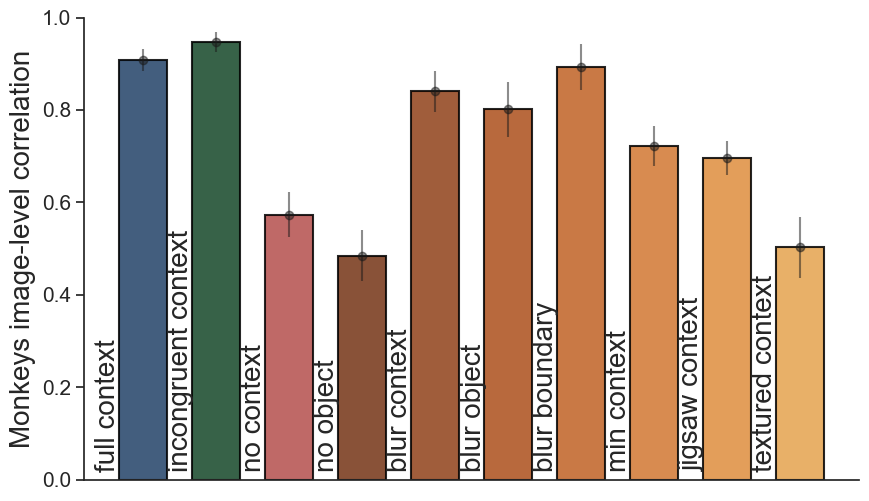

In [406]:
from matplotlib.ticker import MultipleLocator


NB_CONTEXT_TYPES = 10
LABEL_SIZE=20
TICKS_SIZE=15
context_to_num = {'full context': 0, 'incongruent context':1, 
                  'no context':2, 'no object':3, 'blur context':4, 
                  'blur object':5, 'blur boundary':6, 'min context':7, 
                  'jigsaw context':8, 'textured context':9}
num_to_context = {value: key for key, value in context_to_num.items()}
sns.set(rc={"figure.figsize":(10, 6), 'font.family':'arial', 'font.size': 8})
custom_colors=['#174173','#0B4F26','#C53F3B']
color_palette_gradient=sns.color_palette("YlOrBr_r",12)[:7]#sns.color_palette("mako", 12)[:7]
# Combine the custom and gradient palettes
combined_palette = custom_colors + color_palette_gradient#ualitative_colors[:7]#+qualitative_colors[5:]##color_palette_gradient[:]

sns.set_theme(style="white")
sns.set_style('ticks') 

mh_df_context['mean'] = np.clip(mh_df_context.mean(axis=1),a_min=0, a_max=1)  # Calculate average across columns
mh_df_context['std'] = mh_df_context.std(axis=1)  # Calculate standard deviation across columns


ax =sns.barplot(data=mh_df_context, x=mh_df_context.index, y='mean', ec="black", linewidth=1.5,
                 palette=combined_palette, alpha=0.85,width=0.65)
sns.despine()
plt.errorbar(x=list(mh_df_context.index), y=mh_df_context['mean'], yerr=mh_df_context['std'].squeeze()/np.sqrt(10),fmt='o' , color='k', alpha=0.5)
#plt.ylim(0.5)
plt.ylabel(f'Monkeys image-level correlation', fontsize=LABEL_SIZE)
ax.set_xticklabels(list(context_to_num.keys()), rotation=10)
plt.tick_params(axis='y', labelsize=TICKS_SIZE) 
# Add p-value annotations to the bars
#for i, p_value in enumerate(p_values):
#    ax.annotate(f'p={p_value:.3f}', (i+0.5, max(mean_human.values[i],mean_human.values[i+1])  +0.01), ha='center', fontsize=10, color='r' if p_value < 0.05 else 'k')
ax = plt.gca()
#ax.yaxis.set_major_locator(MultipleLocator(0.1))
for i, p in enumerate(ax.patches):
    ax.text(p.get_x() -0.15, 0.03,list(context_to_num.keys())[i], ha='center', rotation=90, fontsize=LABEL_SIZE)
plt.xticks([])
plt.ylim(0,1)
plt.xlabel('')
plt.savefig(f'monkeys_shared_var_by_context_se.eps')


plt.show()

In [407]:
from scipy import stats
for i in range(9):
    for j in range(i+1, 10):
        context_type_1 = band_mh_corrected[i]
        #print(context_type_1)
        context_type_2 = band_mh_corrected[j]#context_grouped.aggregate(lambda x:list(x))['Response'][j]
        t_stat, p_value = stats.ttest_ind(context_type_1, context_type_2)
        if p_value < 0.05:
            print(f'Statistically significant p-value({np.round(p_value,4)}) for {num_to_context[i]} and {num_to_context[j]}')
        

Statistically significant p-value(0.0) for full context and no context
Statistically significant p-value(0.0) for full context and no object
Statistically significant p-value(0.0027) for full context and min context
Statistically significant p-value(0.0005) for full context and jigsaw context
Statistically significant p-value(0.0) for full context and textured context
Statistically significant p-value(0.0001) for incongruent context and no context
Statistically significant p-value(0.0) for incongruent context and no object
Statistically significant p-value(0.0024) for incongruent context and min context
Statistically significant p-value(0.001) for incongruent context and jigsaw context
Statistically significant p-value(0.0001) for incongruent context and textured context
Statistically significant p-value(0.0014) for no context and blur context
Statistically significant p-value(0.0116) for no context and blur object
Statistically significant p-value(0.0425) for no context and min contex

In [42]:
valid_trials =pd.read_pickle('valid_trials_per_sbj.pkl')
valid_trials['pooled monkeys'].shape

(600, 22)

In [458]:
from scipy.stats import spearmanr
def get_splithalf_corr_subsample(data, idx, return_all=False, num_seeds=10, nb_trials_subsample=None):
    # Calculate split-half correlation for 100 seeds
    
    print(f'number of images: {data.shape[0]}, number of trials: {data.shape[1]}')
    split_half_correlation = np.zeros(num_seeds)
                               
    nb_trials = data.shape[1] 
    nb_split_trials= nb_trials//2 if nb_trials_subsample==None else nb_trials_subsample//2
    splits=iter(np.array([
    [
        np.random.seed(seed), 
        np.random.permutation(nb_trials)[0:nb_split_trials],
        np.random.seed(seed),
        np.random.permutation(nb_trials)[nb_split_trials:2*nb_split_trials]
    ][1::2] for seed in range(num_seeds)]).reshape((num_seeds*2, nb_split_trials)) )
    for i in range(num_seeds):
        sh1, sh2 = data[:,next(splits)].mean(axis=1), data[:,next(splits)].mean(axis=1)
        i1_corr_values = spearmanr(sh1[idx], sh2[idx])[0]
        
        i1_shc=np.array(i1_corr_values)
        i1_shc=(2*i1_shc)/(1+i1_shc)
        split_half_correlation[i] = i1_shc
    
    print(f"Average split-half correlation across {num_seeds} seeds I1: {np.nanmean(split_half_correlation):.4f} ")
    if return_all:
        return split_half_correlation
    return split_half_correlation.mean() 

In [459]:
get_splithalf_corr_subsample(valid_trials['pooled monkeys'], list(range(500)))

number of images: 600, number of trials: 22
Average split-half correlation across 10 seeds I1: 0.7505 


0.7504922017036809